# Pain in the Net
Replication of *Deeper Image Quality Transfer: Training Low-Memory Neural Networks for 3D Images*


Code by:

Tyler Spears - tas6hh@virginia.edu

Dr. Tom Fletcher

---

Source work:
`S. B. Blumberg, R. Tanno, I. Kokkinos, and D. C. Alexander, “Deeper Image Quality Transfer: Training Low-Memory Neural Networks for 3D Images,” in Medical Image Computing and Computer Assisted Intervention – MICCAI 2018, Cham, 2018, pp. 118–125, doi: 10.1007/978-3-030-00928-1_14.`


# Imports & Environment Setup

## Imports

In [1]:
# Automatically re-import project-specific modules.
%load_ext autoreload
%autoreload 1

# imports
import collections
import dataclasses
from dataclasses import dataclass
import functools
import io
import datetime
import time
import math
import itertools
import os
import shutil
import pathlib
import copy
import pdb
import inspect
import random
import subprocess
import sys
import warnings
from pathlib import Path
import typing
from typing import Generator
import zipfile

import ants
import dipy
import dipy.core
import dipy.reconst
import dipy.reconst.dti
import dipy.segment.mask
import dotenv

# visualization libraries
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import IPython

# Try importing GPUtil for printing GPU specs.
# May not be installed if using CPU only.
try:
    import GPUtil
except ImportError:
    warnings.warn("WARNING: Package GPUtil not found, cannot print GPU specs")
from tabulate import tabulate
from IPython.display import display, Markdown

# Data management libraries.
import nibabel as nib
import nilearn
import nilearn.plotting
import natsort
from natsort import natsorted
import addict
from addict import Addict
import pprint
from pprint import pprint as ppr

# Computation & ML libraries.
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torchvision
import torchio
import pytorch_lightning as pl

import skimage
import skimage.feature
import skimage.filters
import skimage.measure
import scipy
import einops
import einops.layers
import einops.layers.torch

plt.rcParams.update({"figure.autolayout": True})
plt.rcParams.update({"figure.facecolor": [1.0, 1.0, 1.0, 1.0]})

# Set print options for ndarrays/tensors.
np.set_printoptions(suppress=True, threshold=100, linewidth=88)
torch.set_printoptions(sci_mode=False, threshold=100, linewidth=88)

/opt/miniconda/envs/pitn/lib/python3.8/site-packages/nilearn/datasets/__init__.py:87: FutureWarning:

Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.



In [2]:
# Update notebook's environment variables with direnv.
# This requires the python-dotenv package, and direnv be installed on the system
# This will not work on Windows.
# NOTE: This is kind of hacky, and not necessarily safe. Be careful...
# Libraries needed on the python side:
# - os
# - subprocess
# - io
# - dotenv

# Form command to be run in direnv's context. This command will print out
# all environment variables defined in the subprocess/sub-shell.
command = "direnv exec {} /usr/bin/env".format(os.getcwd())
# Run command in a new subprocess.
proc = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True, cwd=os.getcwd())
# Store and format the subprocess' output.
proc_out = proc.communicate()[0].strip().decode("utf-8")
# Use python-dotenv to load the environment variables by using the output of
# 'direnv exec ...' as a 'dummy' .env file.
dotenv.load_dotenv(stream=io.StringIO(proc_out), override=True);

direnv: loading ~/work/pitn/.envrc
direnv: creating conda environment

CondaValueError: prefix already exists: /opt/miniconda/envs/pitn



In [3]:
# Project-specific scripts
# It's easier to import it this way rather than make an entirely new package, due to
# conflicts with local packages and anaconda installations.
# You made me do this, poor python package management!!
if "PROJECT_ROOT" in os.environ:
    lib_location = str(Path(os.environ["PROJECT_ROOT"]).resolve())
else:
    lib_location = str(Path("../../").resolve())
if lib_location not in sys.path:
    sys.path.insert(0, lib_location)
import lib as pitn

# Include the top-level lib module along with its submodules.
%aimport lib
# Grab all submodules of lib, not including modules outside of the package.
includes = list(
    filter(
        lambda m: m.startswith("lib."),
        map(lambda x: x[1].__name__, inspect.getmembers(pitn, inspect.ismodule)),
    )
)
# Run aimport magic with constructed includes.
ipy = IPython.get_ipython()
ipy.run_line_magic("aimport", ", ".join(includes))

In [4]:
# torch setup
# allow for CUDA usage, if available
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
# keep device as the cpu
# device = torch.device('cpu')
print(device)

cuda


## Specs Recording

In [5]:
%%capture --no-stderr cap
# Capture output and save to log. Needs to be at the *very first* line of the cell.
# Watermark
%load_ext watermark
%watermark --author "Tyler Spears" --updated --iso8601  --python --machine --iversions --githash
if torch.cuda.is_available():

    # GPU information
    # Taken from
    # <https://www.thepythoncode.com/article/get-hardware-system-information-python>.
    # If GPUtil is not installed, skip this step.
    try:
        gpus = GPUtil.getGPUs()
        print("=" * 50, "GPU Specs", "=" * 50)
        list_gpus = []
        for gpu in gpus:
            # get the GPU id
            gpu_id = gpu.id
            # name of GPU
            gpu_name = gpu.name
            driver_version = gpu.driver
            cuda_version = torch.version.cuda
            # get total memory
            gpu_total_memory = f"{gpu.memoryTotal}MB"
            gpu_uuid = gpu.uuid
            list_gpus.append(
                (
                    gpu_id,
                    gpu_name,
                    driver_version,
                    cuda_version,
                    gpu_total_memory,
                    gpu_uuid,
                )
            )

        print(
            tabulate(
                list_gpus,
                headers=(
                    "id",
                    "Name",
                    "Driver Version",
                    "CUDA Version",
                    "Total Memory",
                    "uuid",
                ),
            )
        )
    except NameError:
        print("CUDA Version: ", torch.version.cuda)

else:
    print("CUDA not in use, falling back to CPU")

In [6]:
# cap is defined in an ipython magic command
print(cap)

Author: Tyler Spears

Last updated: 2021-07-06T16:59:21.716761+00:00

Python implementation: CPython
Python version       : 3.8.8
IPython version      : 7.23.1

Compiler    : GCC 7.3.0
OS          : Linux
Release     : 5.4.0-72-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit

Git hash: 0947e9f1e56f6ff8da93e13b91680073797e5e25

ants             : 0.2.7
torchvision      : 0.9.1
torch            : 1.8.1
einops           : 0.3.0
IPython          : 7.23.1
pandas           : 1.2.3
numpy            : 1.20.2
addict           : 2.4.0
skimage          : 0.18.1
matplotlib       : 3.4.1
torchio          : 0.18.37
natsort          : 7.1.1
dipy             : 1.4.0
GPUtil           : 1.4.0
nibabel          : 3.2.1
scipy            : 1.5.3
nilearn          : 0.7.1
seaborn          : 0.11.1
pytorch_lightning: 1.3.2
json             : 2.0.9
sys              : 3.8.8 (default, Feb 24 2021, 21:46:12) 
[GCC 7.3.0]

================================================== GPU 

## Data Variables & Definitions Setup

In [7]:
# Set up directories
data_dir = pathlib.Path(os.environ["DATA_DIR"]) / "hcp"
assert data_dir.exists()
write_data_dir = pathlib.Path(os.environ["WRITE_DATA_DIR"]) / "hcp"
assert write_data_dir.exists()
results_dir = pathlib.Path(os.environ["RESULTS_DIR"])
assert results_dir.exists()

## Experiment Logging Setup

In [8]:
# tensorboard experiment logging setup.
EXPERIMENT_NAME = "lr_norm_with_gt_stats__paper_params"

ts = datetime.datetime.now().replace(microsecond=0).isoformat()
# Break ISO format because many programs don't like having colons ':' in a filename.
ts = ts.replace(":", "_")
experiment_name = ts + "__" + EXPERIMENT_NAME
run_name = experiment_name
# experiment_results_dir = results_dir / experiment_name

# Create temporary directory for results directory, in case experiment does not finish.
tmp_results_dir = results_dir / "tmp"
tmp_dirs = list(tmp_results_dir.glob("*"))

# Only keep up to N tmp results.
n_tmp_to_keep = 3
if len(tmp_dirs) > (n_tmp_to_keep - 1):
    print(f"More than {n_tmp_to_keep} temporary results, culling to the most recent")
    tmps_to_delete = natsorted([str(tmp_dir) for tmp_dir in tmp_dirs])[
        : -(n_tmp_to_keep - 1)
    ]
    for tmp_dir in tmps_to_delete:
        shutil.rmtree(tmp_dir)
        print("Deleted temporary results directory ", tmp_dir)

experiment_results_dir = tmp_results_dir / experiment_name
# Final target directory, to be made when experiment is complete.
final_experiment_results_dir = results_dir / experiment_name

In [9]:
print(experiment_name)

2021-07-06T16_59_21__lr_norm_with_gt_stats__paper_params


In [10]:
# Pass this object into the pytorchlightning Trainer object, for easier logging within
# the training/testing loops.
pl_logger = pl.loggers.TensorBoardLogger(
    tmp_results_dir,
    name=experiment_name,
    version="",
    log_graph=False,
    default_hp_metric=False,
)
# Use the lower-level logger for logging histograms, images, etc.
logger = pl_logger.experiment

# Create a separate txt file to log streams of events & info besides parameters & results.
log_txt_file = Path(logger.log_dir) / "log.txt"
with open(log_txt_file, "a+") as f:
    f.write(f"Experiment Name: {experiment_name}\n")
    f.write(f"Timestamp: {ts}\n")
    # cap is defined in an ipython magic command
    f.write(f"Environment and Hardware Info:\n {cap}\n\n")

# Parameters and Function Definitions

## Parameters

In [11]:
# Dict to keep track of experiment configuration parameters. Will not be logged to
# tensorboard.
exp_params = Addict()
# Dict to keep track of tensorboard hparams that we *specifically* want to compare
# between runs.
compare_hparams = Addict(hparam=Addict(), metric=Addict())

In [12]:
downsample_factor = 2
# Include b=0 shells and b=1000 shells for DTI fitting.
bval_range = (0, 1500)
dti_fit_method = "WLS"
exp_params.update(
    {
        "downsample_factor": downsample_factor,
        "bval_range": bval_range,
        "dti_fit_method": dti_fit_method,
    }
)

### Patch Parameters

In [13]:
# Patch parameters
batch_size = 12
# 6 channels for the 6 DTI components
channels = 6

# Output patch shapes
h_out = 14
w_out = 14
d_out = 14

# This is the factor that determines how over-extended the input patch should be
# relative to the size of the full-res patch.
# $low_res_patch_dim = \frac{full_res_patch_dim}{downsample_factor} \times low_res_sample_extension$
# A value of 1 indicates that the input patch dims will be exactly divided by the
# downsample factor. A dilation > 1 increases the "spatial extent" of the input
# patch, providing information outside of the target HR patch.
low_res_sample_extension = 1.57

# Output shape after shuffling.
output_patch_shape = (channels, h_out, w_out, d_out)
output_spatial_patch_shape = output_patch_shape[1:]

# Input patch parameters
h_in = round(h_out / (downsample_factor) * low_res_sample_extension)
w_in = round(w_out / (downsample_factor) * low_res_sample_extension)
d_in = round(d_out / (downsample_factor) * low_res_sample_extension)
input_patch_shape = (channels, h_in, w_in, d_in)
input_spatial_patch_shape = input_patch_shape[1:]

# Pre-shuffle output patch sizes.
unshuffled_channels_out = channels * downsample_factor ** 3
# Output before shuffling
unshuffled_output_patch_shape = (unshuffled_channels_out, h_in, w_in, d_in)

# Patch size in FR-space when accounting for the low-res over-extension/over-sampling
# factor.
fr_extension_patch_size = tuple(
    np.asarray(input_spatial_patch_shape) * downsample_factor
)
fr_extension_amount = tuple(
    np.asarray(fr_extension_patch_size) - np.asarray(output_spatial_patch_shape)
)

In [14]:
exp_params.patch.update(
    batch_size=batch_size,
    channels=channels,
    low_res_sample_extension=low_res_sample_extension,
    input_shape=input_patch_shape,
    output_shape=output_patch_shape,
)

In [15]:
# Data parameters.
num_subject_samples = 13
# Should the data be normalized as a pre-processing step?
# Can be:
# { None, "channels" }
data_norm_method = "channels"

In [16]:
exp_params.data.update(
    num_subject=num_subject_samples, data_norm_method=data_norm_method
)

### Training and Testing Setup

In [17]:
# Training/testing parameters.
# Percentages will be rounded off to the nearest subject, with the test and validation
# sizes rounded *up*, ensuring at least 1 subject in each.
test_percent = 0.3
val_percent = 0.01
train_percent = 1 - (test_percent + val_percent)

# NN parameters.
max_epochs = 25
network_norm_method = None
train_loss_name = "SSE"

# Optimization parameters.
opt_name = "Adam"
opt_params = {"lr": 1e-3, "betas": (0.9, 0.999)}

# Spline interpolation baseline parameters.
spline_interp_order = 3

In [18]:
# Number of voxels to dilate the mask in FR space.
# Just make it 0...
dilation_size = 0

In [19]:
exp_params.update(test_percent=test_percent)
exp_params.train.update(
    train_percent=train_percent, max_epochs=max_epochs, train_loss_name=train_loss_name
)
exp_params.nn.update(network_norm_method=network_norm_method)
exp_params.opt.update(opt_params)
exp_params.opt.name = opt_name
exp_params.spline.update(order=spline_interp_order)
exp_params.preproc.update(dilation_size=dilation_size)

In [20]:
with open(log_txt_file, "a+") as f:
    f.write(pprint.pformat(exp_params) + "\n")

## Function Definitions

In [21]:
# Utility functions
def patch_center(
    patch: torch.Tensor, sub_sample_strategy="lower", keepdim=False
) -> torch.Tensor:
    """Extract 3D multi-channel patch center.

    Expects patch of shape '[B x C x] W x H x D'

    sub_sample_strategy: str
        Strategy for handling center coordinates of even-sized dimensions.
        Options:
            Strategies over indices:
                'lower': Take the voxel to the left of the center.
                'upper': Take the voxel to the right of the center.

            Strategies over multi-dimensional voxels:
                'max': Take the max of all center voxels.
                'min': Take the minimum of all center voxels.
                'mean': Take the average of all center voxels.
                'agg': Don't reduce at all, and return the center voxels.
    """
    strategy_fn = {
        "idx_fns": {
            "lower".casefold(): lambda i: int(i),
            "upper".casefold(): lambda i: int(i) + 1,
        },
        "vox_fns": {
            "max".casefold(): lambda p: torch.amax(p, dim=(-3, -2, -1), keepdim=True),
            "min".casefold(): lambda p: torch.amin(p, dim=(-3, -2, -1), keepdim=True),
            "mean".casefold(): lambda p: p.mean(dim=(-3, -2, -1), keepdim=True),
            "agg".casefold(): lambda p: p,
        },
    }

    strat = sub_sample_strategy.casefold()
    if (strat not in strategy_fn["idx_fns"].keys()) and (
        strat not in strategy_fn["vox_fns"].keys()
    ):
        raise ValueError(
            f"ERROR: Invalid strategy; got {sub_sample_strategy}, expected one of"
            + f"{list(strategy_fn['idx_fns'].keys()) + list(strategy_fn['vox_fns'].keys())}"
        )
    patch_spatial_shape = patch.shape[-3:]
    centers = torch.as_tensor(patch_spatial_shape) / 2
    center = list()
    for dim in centers:
        if int(dim) != dim:
            dim = slice(int(math.floor(dim)), int(math.ceil(dim)))
        elif strat in strategy_fn["idx_fns"].keys():
            dim = int(strategy_fn["idx_fns"][strat](dim))
            dim = slice(dim, dim + 1)
        elif strat in strategy_fn["vox_fns"].keys():
            dim = slice(int(dim), int(dim) + 2)
        else:
            raise ValueError("ERROR: Invalid strategy")
        center.append(dim)

    center_patches = patch[..., center[0], center[1], center[2]]

    if (
        center_patches.shape[-3:] != (1, 1, 1)
        and strat in strategy_fn["vox_fns"].keys()
    ):
        center_patches = strategy_fn["vox_fns"][strat](center_patches)

    if not keepdim:
        center_patches = center_patches.squeeze()

    return center_patches

In [22]:
BoxplotStats = collections.namedtuple(
    "BoxplotStats",
    ["low_outliers", "low", "q1", "median", "q3", "high", "high_outliers"],
)


def batch_boxplot_stats(batch):
    """Quick calculation of a batch of 1D values for showing boxplot stats."""
    q1, median, q3 = np.quantile(batch, q=[0.25, 0.5, 0.75], axis=1)
    iqr = q3 - q1
    low = q1 - (1.5 * iqr)
    high = q3 + (1.5 * iqr)
    low_outliers = list()
    high_outliers = list()
    # Number of outliers may be different for each batch, so it needs to be a list of
    # arrays.
    for i_batch in range(len(batch)):
        batch_i = batch[i_batch]
        low_i = low[i_batch]
        low_outliers.append(batch_i[np.where(batch_i < low_i)])
        high_i = high[i_batch]
        high_outliers.append(batch_i[np.where(batch_i > high_i)])

    return BoxplotStats(low_outliers, low, q1, median, q3, high, high_outliers)

In [23]:
# Quick check on full volume/batch distributions.


def desc_channel_dists(vols, mask=None):
    t_vols = torch.as_tensor(vols)

    if t_vols.ndim == 4:
        t_vols = t_vols[None, ...]

    if mask is not None:
        t_mask = torch.as_tensor(mask)
        if mask.ndim == 4:
            mask = mask[0]
    else:
        t_mask = torch.ones_like(t_vols[0, 0]).bool()

    results = "means | vars\n"
    for t_vol_i in t_vols:
        masked_vol = torch.masked_select(t_vol_i, t_mask).reshape(t_vol_i.shape[0], -1)
        mean_i = torch.mean(masked_vol, dim=1)
        var_i = torch.var(masked_vol, dim=1)
        mvs = [
            (f"{mv[0]} | {mv[1]}\n")
            for mv in torch.stack([mean_i, var_i], dim=-1).tolist()
        ]
        results = results + "".join(mvs)
        results = results + ("=" * (len(mvs[-1]) - 1)) + "\n"

    return results

# Data Loading

## Subject ID Selection

In [24]:
# Find data directories for each subject.
subj_dirs: dict = dict()

selected_ids = [
    "397154",
    "224022",
    "140117",
    "751348",
    "894774",
    "156637",
    "227432",
    "303624",
    "185947",
    "810439",
    "753251",
    "644246",
    "141422",
    "135528",
    "103010",
    "700634",
]

## Sub-set the chosen participants for dev and debugging!
selected_ids = random.sample(selected_ids, num_subject_samples)
warnings.warn(
    "WARNING: Sub-selecting participants for dev and debugging. "
    + f"Subj IDs selected: {selected_ids}"
)
# ### A nested warning! For debugging only.
# warnings.warn("WARNING: Mixing training and testing subjects")
# selected_ids.append(selected_ids[0])
# ###
##

selected_ids = natsorted(list(map(lambda s: int(s), selected_ids)))

for subj_id in selected_ids:
    subj_dirs[subj_id] = data_dir / f"{subj_id}/T1w/Diffusion"
    assert subj_dirs[subj_id].exists()
subj_dirs

/tmp/ipykernel_173232/2765378097.py:25: UserWarning:




{103010: PosixPath('/mnt/storage/data/pitn/hcp/103010/T1w/Diffusion'),
 140117: PosixPath('/mnt/storage/data/pitn/hcp/140117/T1w/Diffusion'),
 141422: PosixPath('/mnt/storage/data/pitn/hcp/141422/T1w/Diffusion'),
 156637: PosixPath('/mnt/storage/data/pitn/hcp/156637/T1w/Diffusion'),
 185947: PosixPath('/mnt/storage/data/pitn/hcp/185947/T1w/Diffusion'),
 224022: PosixPath('/mnt/storage/data/pitn/hcp/224022/T1w/Diffusion'),
 227432: PosixPath('/mnt/storage/data/pitn/hcp/227432/T1w/Diffusion'),
 303624: PosixPath('/mnt/storage/data/pitn/hcp/303624/T1w/Diffusion'),
 397154: PosixPath('/mnt/storage/data/pitn/hcp/397154/T1w/Diffusion'),
 644246: PosixPath('/mnt/storage/data/pitn/hcp/644246/T1w/Diffusion'),
 751348: PosixPath('/mnt/storage/data/pitn/hcp/751348/T1w/Diffusion'),
 810439: PosixPath('/mnt/storage/data/pitn/hcp/810439/T1w/Diffusion'),
 894774: PosixPath('/mnt/storage/data/pitn/hcp/894774/T1w/Diffusion')}

The 90 scans are taken from the $b=1000 \ s/mm^2$. However, the $b=0$ shells are still required for fitting the diffusion tensors (DTI's), so those will need to be kept, too.

To find those, sub-select with the $0 < bvals < 1500$, or roughly thereabout. A b-val of $995$ or $1005$ still counts as a b=1000.

In [25]:
with open(log_txt_file, "a+") as f:
    f.write(f"Selected Subjects: {selected_ids}\n")

logger.add_text("subjs", pprint.pformat(selected_ids))

## Loading and Preprocessing

In [26]:
# Set up the transformation pipeline.

preproc_transforms = torchio.Compose(
    [
        torchio.transforms.ToCanonical(include=("dwi", "brain_mask"), copy=False),
        pitn.transforms.BValSelectionTransform(
            bval_range=bval_range,
            bval_key="bvals",
            bvec_key="bvecs",
            include="dwi",
            copy=False,
        ),
        # Pad by the dilation factor, then dilate the mask.
        torchio.transforms.Pad(
            dilation_size,
            padding_mode=0,
            include=("dwi", "brain_mask"),
            copy=False,
        ),
        pitn.transforms.DilateMaskTransform(
            dilation_size=dilation_size, include=("brain_mask",), copy=False
        ),
        # Pad by the amount of extension voxels in FR space, so LR indices cannot
        # go out of bounds.
        torchio.transforms.Pad(
            fr_extension_amount,
            padding_mode=0,
            include=("dwi", "brain_mask"),
            copy=False,
        ),
        # Ensure FR dims are divisible by the downsample factor, to more reliably
        # convert between FR indices and LR indices.
        torchio.transforms.EnsureShapeMultiple(
            downsample_factor, method="pad", include=("dwi", "brain_mask"), copy=False
        ),
        pitn.transforms.MeanDownsampleTransform(
            downsample_factor,
            include=("dwi", "brain_mask"),
            keep={"dwi": "fr_dwi", "brain_mask": "fr_brain_mask"},
            copy=False,
        ),
        pitn.transforms.RenameImageTransform(
            {"dwi": "lr_dwi", "brain_mask": "lr_brain_mask"}, copy=False
        ),
        pitn.transforms.FitDTITransform(
            "bvals",
            "bvecs",
            "fr_brain_mask",
            fit_method=dti_fit_method,
            include=("fr_dwi"),
            #             cache_dir="./.cache",
            copy=False,
        ),
        pitn.transforms.FitDTITransform(
            "bvals",
            "bvecs",
            "lr_brain_mask",
            fit_method=dti_fit_method,
            include=("lr_dwi"),
            #             cache_dir="./.cache",
            copy=False,
        ),
        pitn.transforms.RenameImageTransform(
            {"fr_dwi": "fr_dti", "lr_dwi": "lr_dti"}, copy=False
        ),
        pitn.transforms.ImageToDictTransform(
            include=("lr_dti", "lr_brain_mask"), copy=False
        ),
    ]
)

In [27]:
# Import all image data into a sequence of `torchio.Subject` objects.
subj_data: dict = dict()
summary_stats_fmt = "github"
summary_stats_header = [
    "Subj ID",
    "Resolution",
    "Channel Index",
    "Mean",
    "Var",
    "Num Outliers (Lower)",
    "Low",
    "25th Percentile",
    "Median",
    "75th Percentile",
    "High",
    "Num Outliers (Upper)",
]
dti_channel_names = ["Dxx", "Dxy", "Dyy", "Dxz", "Dyz", "Dzz"]
subj_stats = dict()
# Dictionary to hold the subject's summary statistics if image-level or global
# normalization is used.
norm_subj_stats = dict()
for k in summary_stats_header:
    subj_stats[k] = list()
    norm_subj_stats[k] = list()

for subj_id, subj_dir in subj_dirs.items():
    # Sub-select volumes with only bvals in a certain range. E.x. bvals <= 1100 mm/s^2,
    # a.k.a. only the b=0 and b=1000 shells.
    bvals = torch.as_tensor(np.loadtxt(subj_dir / "bvals").astype(int))
    bvecs = torch.as_tensor(np.loadtxt(subj_dir / "bvecs"))
    # Reshape to be N x 3
    if bvecs.shape[0] == 3:
        bvecs = bvecs.T

    brain_mask = torchio.LabelMap(
        subj_dir / "nodif_brain_mask.nii.gz",
        type=torchio.LABEL,
        channels_last=False,
    )
    brain_mask.set_data(brain_mask.data.bool())
    mask_volume = brain_mask["data"].sum()
    print(f"Brain mask volume before dilation: {mask_volume}")
    dwi = torchio.ScalarImage(
        subj_dir / "data.nii.gz",
        type=torchio.INTENSITY,
        bvals=bvals,
        bvecs=bvecs,
        reader=pitn.io.nifti_reader,
        channels_last=True,
    )

    subject_dict = torchio.Subject(subj_id=subj_id, dwi=dwi, brain_mask=brain_mask)
    preproced_subj = preproc_transforms(subject_dict)
    dilated_mask_volume = preproced_subj["fr_brain_mask"]["data"].sum()
    print(f"Dilated mask volume: {dilated_mask_volume}")
    print(f"Mask volume difference: {dilated_mask_volume - mask_volume}")
    # Subject-and-channel-wise standardization/normalization of both the LR and FR vols.
    # Note that LR and FR images should have the same means, but *not* the same variances.
    fr_vol = preproced_subj.fr_dti.tensor
    fr_mask = preproced_subj.fr_brain_mask.tensor.bool()
    masked_fr_vol = torch.masked_select(fr_vol, fr_mask).reshape(fr_vol.shape[0], -1)
    fr_channel_means = masked_fr_vol.mean(dim=1)
    fr_channel_means = fr_channel_means.reshape(-1, 1, 1, 1)
    fr_channel_vars = masked_fr_vol.var(dim=1)
    fr_channel_vars = fr_channel_vars.reshape(-1, 1, 1, 1)

    # Store subject-and-channel-wise means and vars in order to reverse the normalization
    # for the final visualization/output.
    preproced_subj["fr_means"] = fr_channel_means.detach().cpu().numpy()
    preproced_subj["fr_vars"] = fr_channel_vars.detach().cpu().numpy()

    lr_vol = preproced_subj.lr_dti["data"]
    lr_mask = preproced_subj.lr_brain_mask["data"].bool()
    masked_lr_vol = torch.masked_select(lr_vol, lr_mask).reshape(lr_vol.shape[0], -1)
    lr_channel_means = masked_lr_vol.mean(dim=1)
    lr_channel_means = lr_channel_means.reshape(-1, 1, 1, 1)
    lr_channel_vars = masked_lr_vol.var(dim=1)
    lr_channel_vars = lr_channel_vars.reshape(-1, 1, 1, 1)

    # Store subject-and-channel-wise means and vars in order to reverse the normalization
    # for the final visualization/output.
    preproced_subj["lr_means"] = lr_channel_means.detach().cpu().numpy()
    preproced_subj["lr_vars"] = lr_channel_vars.detach().cpu().numpy()

    # Print and log some statistics of the subject data.
    # Add FR stats to the summary table.
    fr_vol_stats = batch_boxplot_stats(masked_fr_vol)
    subj_stats["Subj ID"].extend(
        list(itertools.repeat(subj_id, len(fr_vol_stats.median)))
    )
    subj_stats["Resolution"].extend(
        list(itertools.repeat(tuple(fr_vol.shape[1:]), len(fr_vol_stats.median)))
    )
    subj_stats["Channel Index"].extend(dti_channel_names)
    subj_stats["Mean"].extend(fr_channel_means.cpu().flatten().tolist())
    subj_stats["Var"].extend(fr_channel_vars.cpu().flatten().tolist())
    # Append FR boxplot stats to their corresponding fields. In other words, all columns
    # after the var column.
    for i, field in enumerate(
        summary_stats_header[(summary_stats_header.index("Var") + 1) :]
    ):
        if "Num" in field:
            subj_stats[field].extend(list(map(len, fr_vol_stats[i])))
        else:
            subj_stats[field].extend(fr_vol_stats[i])

    # Add LR stats to the summary table.
    lr_vol_stats = batch_boxplot_stats(masked_lr_vol)
    subj_stats["Subj ID"].extend(
        list(itertools.repeat(subj_id, len(fr_vol_stats.median)))
    )
    subj_stats["Resolution"].extend(
        list(itertools.repeat(tuple(lr_vol.shape[1:]), len(lr_vol_stats.median)))
    )
    subj_stats["Channel Index"].extend(dti_channel_names)
    subj_stats["Mean"].extend(lr_channel_means.cpu().flatten().tolist())
    subj_stats["Var"].extend(lr_channel_vars.cpu().flatten().tolist())
    # Append LR boxplot stats to their corresponding fields. In other words, all columns
    # after the var column.
    for i, field in enumerate(
        summary_stats_header[(summary_stats_header.index("Var") + 1) :]
    ):
        if "Num" in field:
            subj_stats[field].extend(list(map(len, lr_vol_stats[i])))
        else:
            subj_stats[field].extend(lr_vol_stats[i])

    # Optionally apply image-level or global normalization.
    if isinstance(data_norm_method, str) and "channel" in data_norm_method.casefold():

        # Standardize the volumes.
        preproced_subj.fr_dti.set_data(
            pitn.data.norm.normalize_dti(fr_vol, fr_channel_means, fr_channel_vars)
        )
        preproced_subj.lr_dti["data"] = pitn.data.norm.normalize_dti(
            lr_vol, fr_channel_means, fr_channel_vars
        )

        # Re-calculate the same statistics post-normalization.
        fr_vol = preproced_subj.fr_dti["data"]
        fr_mask = preproced_subj.fr_brain_mask["data"].bool()
        masked_fr_vol = torch.masked_select(fr_vol, fr_mask).reshape(
            fr_vol.shape[0], -1
        )
        fr_channel_means = masked_fr_vol.mean(dim=1)
        fr_channel_means = fr_channel_means.reshape(-1, 1, 1, 1)
        fr_channel_vars = masked_fr_vol.var(dim=1)
        fr_channel_vars = fr_channel_vars.reshape(-1, 1, 1, 1)
        # Print and log some statistics of the subject data.
        # Add FR stats to the summary table.
        fr_vol_stats = batch_boxplot_stats(masked_fr_vol)
        norm_subj_stats["Subj ID"].extend(
            list(itertools.repeat(subj_id, len(fr_vol_stats.median)))
        )
        norm_subj_stats["Resolution"].extend(
            list(itertools.repeat(tuple(fr_vol.shape[1:]), len(fr_vol_stats.median)))
        )
        norm_subj_stats["Channel Index"].extend(dti_channel_names)
        norm_subj_stats["Mean"].extend(fr_channel_means.cpu().flatten().tolist())
        norm_subj_stats["Var"].extend(fr_channel_vars.cpu().flatten().tolist())
        # Append FR boxplot stats to their corresponding fields. In other words, all
        # columns after the var column.
        for i, field in enumerate(
            summary_stats_header[(summary_stats_header.index("Var") + 1) :]
        ):
            if "Num" in field:
                norm_subj_stats[field].extend(list(map(len, fr_vol_stats[i])))
            else:
                norm_subj_stats[field].extend(fr_vol_stats[i])

        # Add LR stats to the summary table.
        lr_vol = preproced_subj.lr_dti["data"]
        lr_mask = preproced_subj.lr_brain_mask["data"].bool()
        masked_lr_vol = torch.masked_select(lr_vol, lr_mask).reshape(
            lr_vol.shape[0], -1
        )
        lr_channel_means = masked_lr_vol.mean(dim=1)
        lr_channel_means = lr_channel_means.reshape(-1, 1, 1, 1)
        lr_channel_vars = masked_lr_vol.var(dim=1)
        lr_channel_vars = lr_channel_vars.reshape(-1, 1, 1, 1)

        lr_vol_stats = batch_boxplot_stats(masked_lr_vol)
        norm_subj_stats["Subj ID"].extend(
            list(itertools.repeat(subj_id, len(lr_vol_stats.median)))
        )
        norm_subj_stats["Resolution"].extend(
            list(itertools.repeat(tuple(lr_vol.shape[1:]), len(lr_vol_stats.median)))
        )
        norm_subj_stats["Channel Index"].extend(dti_channel_names)
        norm_subj_stats["Mean"].extend(lr_channel_means.cpu().flatten().tolist())
        norm_subj_stats["Var"].extend(lr_channel_vars.cpu().flatten().tolist())
        # Append LR boxplot stats to their corresponding fields. In other words, all columns
        # after the var column.
        for i, field in enumerate(
            summary_stats_header[(summary_stats_header.index("Var") + 1) :]
        ):
            if "Num" in field:
                norm_subj_stats[field].extend(list(map(len, lr_vol_stats[i])))
            else:
                norm_subj_stats[field].extend(lr_vol_stats[i])

    #     with open(log_txt_file, "a+") as f:
    #         f.write(f"Subject ID {subj_id} masked voxel distribution by channel:\n")
    #         f.write(
    #             f"{desc_channel_dists(preproced_subj['fr_dti']['data'], preproced_subj['fr_brain_mask']['data'].bool())}\n"
    #         )

    subj_data[subj_id] = preproced_subj
    print("=" * 20)
#     breakpoint()

print("===Data Loaded & Transformed===")

subj_stats_str = tabulate(
    subj_stats, headers=summary_stats_header, tablefmt=summary_stats_fmt
)

if norm_subj_stats["Subj ID"]:
    norm_subj_stats_str = tabulate(
        norm_subj_stats, headers=summary_stats_header, tablefmt=summary_stats_fmt
    )
else:
    norm_subj_stats_str = ""

Brain mask volume before dilation: 835217
Loading NIFTI image: /mnt/storage/data/pitn/hcp/103010/T1w/Diffusion/data.nii.gz
	Loaded NIFTI image
Selecting with bvals: Subject 103010...Selected
Downsampling: Subject 103010...Downsampled
Fitting to DTI: Subject 103010...Not cached
...DTI shape: (6, 162, 190, 162)...Fitted DTI model: torch.Size([6, 162, 190, 162])
Fitting to DTI: Subject 103010...Not cached
...DTI shape: (6, 81, 95, 81)...Fitted DTI model: torch.Size([6, 81, 95, 81])
Dilated mask volume: 835217
Mask volume difference: 0
Brain mask volume before dilation: 730310
Loading NIFTI image: /mnt/storage/data/pitn/hcp/140117/T1w/Diffusion/data.nii.gz
	Loaded NIFTI image
Selecting with bvals: Subject 140117...Selected
Downsampling: Subject 140117...Downsampled
Fitting to DTI: Subject 140117...Not cached
...DTI shape: (6, 162, 190, 162)...Fitted DTI model: torch.Size([6, 162, 190, 162])
Fitting to DTI: Subject 140117...Not cached
...DTI shape: (6, 81, 95, 81)...Fitted DTI model: torch.

In [28]:
# g = [vol[None, ...] for vol in fr_vol[:, :, :, 100]]
# g.extend([vol[None, ...] for vol in subj_data[810439].fr_dti.data[:, :, :, 100]])
# g = torchvision.utils.make_grid(g, nrow=6)
# plt.figure(dpi=120, figsize=(4, 9))
# plt.imshow(np.rot90(g.cpu().numpy()[0]))
# plt.colorbar()
# # plt.imshow().cpu().numpy())
# # subj_data[810439].fr_dti.data

In [29]:
with open(log_txt_file, "a+") as f:
    f.write(f"Preprocessing transformation pipeline: {str(preproc_transforms)}\n")
    f.write(f"Data Summary Statistics, no normalization:\n {subj_stats_str}\n\n")

# If the subject data was normalized and those stats were recorded, log those stats.
if norm_subj_stats_str:
    with open(log_txt_file, "a+") as f:
        f.write(
            f"Data Summary Statistics, after normalization:\n {norm_subj_stats_str}\n\n"
        )

In [30]:
# display(Markdown(subj_stats_str))

In [31]:
# display(Markdown(norm_subj_stats_str))

In [32]:
subj_dataset = torchio.SubjectsDataset(list(subj_data.values()), load_getitem=False)

# Model Training

## Set Up Patch-Based Data Loaders

In [33]:
# Data train/validation/test split

num_subjs = len(subj_dataset)
num_test_subjs = int(np.ceil(num_subjs * test_percent))
num_val_subjs = int(np.ceil(num_subjs * val_percent))
num_train_subjs = num_subjs - (num_test_subjs + num_val_subjs)
subj_list = subj_dataset.dry_iter()
# Randomly shuffle the list of subjects, then choose the first `num_test_subjs` subjects
# for testing.
random.shuffle(subj_list)

test_dataset = torchio.SubjectsDataset(subj_list[:num_test_subjs], load_getitem=False)
# Choose the remaining for training/validation.
# If only 1 subject is available, assume this is a debugging run.
if num_subjs == 1 and num_train_subjs == 0:
    print("DEBUG: Only 1 subject with no training subjects, mixing train and test set")
    subj_list = subj_list[:]
    num_train_subjs = num_test_subjs
else:
    subj_list = subj_list[num_test_subjs:]

val_dataset = torchio.SubjectsDataset(subj_list[:num_val_subjs], load_getitem=False)
subj_list = subj_list[num_val_subjs:]

train_dataset = torchio.SubjectsDataset(subj_list, load_getitem=False)

# Training patch sampler, random across all patches of all volumes.
train_sampler = pitn.samplers.MultiresSampler(
    source_img_key="fr_dti",
    low_res_key="lr_dti",
    downsample_factor=downsample_factor,
    label_name="fr_brain_mask",
    source_spatial_patch_size=output_spatial_patch_shape,
    low_res_spatial_patch_size=input_spatial_patch_shape,
    label_probabilities={0: 0, 1: 1},
    source_mask_key="fr_brain_mask",
)

patches_per_subj = 8000
# Hold enough for 2 epochs at a time.
queue_max_length = patches_per_subj * num_train_subjs

# Set up a torchio.Queue to act as a sampler proxy for the torch DataLoader
train_queue = torchio.Queue(
    train_dataset,
    max_length=queue_max_length,
    samples_per_volume=patches_per_subj,
    sampler=train_sampler,
    shuffle_patches=True,
    shuffle_subjects=True,
    num_workers=7,
    #     verbose=True,
)

# Create partial function to collect list of samples and form a tuple of tensors.
collate_fn = functools.partial(
    pitn.samplers.collate_subj_mask,
    full_res_key="fr_dti",
    low_res_key="lr_dti",
    full_res_mask_key="fr_brain_mask",
)

train_loader = torch.utils.data.DataLoader(
    train_queue,
    batch_size=batch_size,
    collate_fn=collate_fn,
    pin_memory=True,
    num_workers=0,
)

# Set up validation and testing objects.

# Validation samplers/datasets
# Alter the collate function to include locations, masks, and subj ids in batches for
# visualization, reconstruction, analysis, etc.
# This collate function determines the contents of the `batch` parameters in the
# PytorchLightning system's `test_step` and `validation_step` methods.
collate_meta = functools.partial(
    pitn.viz.collate_locs_and_keys,
    full_res_key="fr_dti",
    low_res_key="lr_dti",
    full_res_mask_key="source_mask",
    subj_ids="subj_id",
    fr_means="fr_means",
    fr_vars="fr_vars",
)

# No backward pass is performed here, so we can increase the batch size to lower
# inference time.
tv_batch_size = 128
val_samplers = list()
for subj in val_dataset.dry_iter():
    val_sampler_i = pitn.samplers.MultiresGridSampler(
        subject=subj,
        source_img_key="fr_dti",
        low_res_key="lr_dti",
        downsample_factor=downsample_factor,
        source_spatial_patch_size=output_spatial_patch_shape,
        low_res_spatial_patch_size=input_spatial_patch_shape,
        low_res_sample_extension=low_res_sample_extension,
        patch_overlap=0,
        # Due to the oversampling in the LR->HR patch mapping, a mask is necessary
        # to avoid sampling from out of bounds.
        source_mask=subj["fr_brain_mask"].tensor[0].bool(),
        mask_patch_filter_fn=lambda p: bool(p.any()),
        subj_keys_to_copy=("fr_means", "fr_vars", "subj_id"),
    )

    val_samplers.append(val_sampler_i)

concat_val_dataset = torch.utils.data.ConcatDataset(val_samplers)
val_loader = torch.utils.data.DataLoader(
    concat_val_dataset,
    batch_size=tv_batch_size,
    collate_fn=collate_meta,
    pin_memory=True,
    num_workers=2,
)

# Test samplers/datasets
test_samplers = list()
for subj in test_dataset.dry_iter():
    test_sampler_i = pitn.samplers.MultiresGridSampler(
        subject=subj,
        source_img_key="fr_dti",
        low_res_key="lr_dti",
        downsample_factor=downsample_factor,
        source_spatial_patch_size=output_spatial_patch_shape,
        low_res_spatial_patch_size=input_spatial_patch_shape,
        patch_overlap=0,
        low_res_sample_extension=low_res_sample_extension,
        # Due to the oversampling in the LR->HR patch mapping, a mask is necessary
        # to avoid sampling from out of bounds.
        source_mask=subj["fr_brain_mask"].tensor[0].bool(),
        mask_patch_filter_fn=lambda p: bool(p.any()),
        subj_keys_to_copy=("fr_means", "fr_vars", "subj_id"),
    )

    test_samplers.append(test_sampler_i)

concat_test_dataset = torch.utils.data.ConcatDataset(test_samplers)
test_loader = torch.utils.data.DataLoader(
    concat_test_dataset,
    batch_size=tv_batch_size,
    collate_fn=collate_meta,
    pin_memory=True,
    num_workers=4,
)


print("Training subject ID(s): ", [s.subj_id for s in train_dataset.dry_iter()])
print("Validation subject ID(s): ", [s.subj_id for s in val_dataset.dry_iter()])
print("Test subject ID(s): ", [s.subj_id for s in test_dataset.dry_iter()])

Training subject ID(s):  [397154, 894774, 303624, 103010, 141422, 156637, 227432, 751348]
Validation subject ID(s):  [644246]
Test subject ID(s):  [224022, 140117, 810439, 185947]


### Bounding Box Selection for Visualization During Training

In [34]:
# Create bbox coordinates for visualizing validation aggregate patches.
# NOTE: This presumes that there are no overlap patches in the validation step, and that
# each validation volume is divisible by the patch shape in each spatial dimension.
bbox_coords = list()
region_size = torch.as_tensor(output_spatial_patch_shape) * 3
vol_shape = torch.as_tensor(val_dataset.dry_iter()[0]["fr_dti"].shape[1:])
possible_bbox_ini = [
    torch.arange(0, vol_shape[0], output_spatial_patch_shape[0]),
    torch.arange(0, vol_shape[1], output_spatial_patch_shape[1]),
    torch.arange(0, vol_shape[2], output_spatial_patch_shape[2]),
]

# Create bbox that spans roughly the center of the volume.
bbox_idx_ini = list()
for possible_bbox_part in possible_bbox_ini:
    num_parts = len(possible_bbox_part)
    bbox_idx_ini.append(possible_bbox_part[round(num_parts * 0.4)])
bbox_idx_ini = torch.as_tensor(bbox_idx_ini)

bbox_coord = torch.cat([bbox_idx_ini, bbox_idx_ini + region_size])
bbox_coords.append(bbox_coord)

In [35]:
# Create bbox that covers an edge.
vol_mask = val_dataset.dry_iter()[0]["fr_brain_mask"].tensor[0]
bbox_mask_coverage = list()
possible_bbox_coords_ini = list(itertools.product(*possible_bbox_ini))
for bbox_w, bbox_h, bbox_d in possible_bbox_coords_ini:
    bbox_start = (bbox_w, bbox_h, bbox_d)
    bbox_end = (
        bbox_start[0] + output_spatial_patch_shape[0],
        bbox_start[1] + output_spatial_patch_shape[1],
        bbox_start[2] + output_spatial_patch_shape[2],
    )
    patch = vol_mask[
        bbox_start[0] : bbox_end[0],
        bbox_start[1] : bbox_end[1],
        bbox_start[2] : bbox_end[2],
    ]
    bbox_mask_coverage.append(patch.sum().item())

# Now search all coordinates' mask coverages for the one closest to a 50% of the total
# patch volume.
patch_vol = np.prod(output_spatial_patch_shape)
target_mask_vol = patch_vol // (2 ** 3)

bbox_coord_idx = np.argmin(np.abs(np.asarray(bbox_mask_coverage) - patch_vol))
bbox_idx_ini = torch.tensor(possible_bbox_coords_ini[bbox_coord_idx])
bbox_coord = torch.cat([bbox_idx_ini, bbox_idx_ini + region_size])
bbox_coords.append(bbox_coord)

In [36]:
bbox_coords = torch.stack(bbox_coords)

bbox_coords

tensor([[ 70,  84,  70, 112, 126, 112],
        [ 42,  56,  42,  84,  98,  84]])

In [37]:
with open(log_txt_file, "a+") as f:
    f.write(f"Training Set Subjects: {[s.subj_id for s in train_dataset.dry_iter()]}\n")
    f.write(f"Validation Set Subjects: {[s.subj_id for s in val_dataset.dry_iter()]}\n")
    f.write(f"Test Set Subjects: {[s.subj_id for s in test_dataset.dry_iter()]}\n")

logger.add_text("train_subjs", str([s.subj_id for s in train_dataset.dry_iter()]))
logger.add_text("val_subjs", str([s.subj_id for s in val_dataset.dry_iter()]))
logger.add_text("test_subjs", str([s.subj_id for s in test_dataset.dry_iter()]))

## Model Definition

In [38]:
# Full pytorch-lightning module for contained training, validation, and testing.
debug_prob_threshold = -0.0005


class DIQTSystem(pl.LightningModule):

    # Specify training loss methods with mappings to their names as strings.
    loss_methods = {
        "MSE".casefold(): torch.nn.MSELoss(reduction="mean"),
        "SSE".casefold(): torch.nn.MSELoss(reduction="sum"),
        "RMSE".casefold(): lambda y_hat, y: torch.sqrt(
            F.mse_loss(y_hat, y, reduction="mean")
        ),
        "L1".casefold(): torch.nn.L1Loss(reduction="mean"),
    }

    def __init__(
        self,
        channels,
        downsample_factor,
        train_loss_method: str,
        opt_params: dict,
        norm_method=None,
        val_viz_bboxes=None,
        val_patch_overlap=(0, 0, 0),
        val_viz_every_n_epochs=1,
    ):
        super().__init__()

        self._channels = channels
        self._downsample_factor = downsample_factor

        # Parameters
        # Network parameters
        self.net = pitn.nn.models.ThreeConv(
            self._channels, self._downsample_factor, norm_method=norm_method
        )
        self._norm_eps = 1e-10
        ## Training parameters
        self.opt_params = opt_params

        # Select loss method as either one of the pre-selected methods, or a custom
        # callable.
        try:
            self._loss_fn = self.loss_methods[train_loss_method.casefold()]
        except (AttributeError, KeyError):
            if callable(train_loss_method):
                self._loss_fn = train_loss_method
            else:
                raise ValueError(
                    f"ERROR: Invalid loss function specification {train_loss_method}, "
                    + f"expected one of {self.loss_methods.keys()} or a callable."
                )

        # Sub-regions of the volume that should be logged in validation.
        if val_viz_bboxes is None:
            self.val_bboxes = torch.zeros(0, 6)
        else:
            self.val_bboxes = val_viz_bboxes
        self.val_patch_overlap = val_patch_overlap

        # Store the validation set min and max for each bounding box, to keep a consistent
        # color scale on the color bar.
        self.val_vmin = [
            None,
        ] * self.val_bboxes.shape[0]
        self.val_vmax = [
            None,
        ] * self.val_bboxes.shape[0]
        self.val_viz_every_n_epochs = val_viz_every_n_epochs
        self._last_val_viz_epoch = -1

        # My own dinky logging object.
        self.plain_log = Addict(
            {
                "train_loss": list(),
                "val_loss": list(),
                "test_loss": list(),
                "spline_loss": list(),
                "viz": Addict(
                    {
                        "test_preds": Addict(),
                        "test_squared_error": Addict(),
                    }
                ),
            }
        )

    @staticmethod
    def normalize_with_layer(norm_layer, y):

        if norm_layer is not None:
            if not norm_layer.track_running_stats:
                y = norm_layer(y)
            else:
                if isinstance(norm_layer, torch.nn.InstanceNorm3d):
                    y = F.instance_norm(
                        y,
                        eps=norm_layer.eps,
                    )
                elif isinstance(norm_layer, torch.nn.BatchNorm3d):
                    y = F.batch_norm(
                        y,
                        eps=norm_layer.eps,
                    )

        return y

    def forward(self, x):
        y = self.net(x)
        return y

    def training_step(self, batch, batch_idx):
        x, y, masks = batch

        y_pred = self.net(x, norm_output=False)
        #         if self.net.norm is not None:
        #             y = self.normalize_with_layer(self.net.norm, y)

        loss = self._loss_fn(
            torch.masked_select(y_pred, masks), torch.masked_select(y, masks)
        )

        self.log("train_loss", loss, prog_bar=True)
        self.plain_log["train_loss"].append(float(loss.cpu()))
        return loss

    def validation_step(self, batch: dict, batch_idx):
        # The validation samples include extra metadata regarding the patches.
        batch = Addict(batch)
        x = batch.low_res
        y = batch.full_res
        y_locs = batch.full_res_locs
        y_masks = batch.full_res_masks
        fr_means = batch.fr_means
        fr_vars = batch.fr_vars

        y_pred = self.net(x, norm_output=False)

        # Denormalize the patches and predictions and calculate RMSE on intensity values
        # in the original data's scale.
        if (not (fr_means == 0).all()) and (not (fr_vars == 1).all()):
            y = pitn.data.norm.denormalize_batch(
                y, mean=fr_means, var=fr_vars, eps=self._norm_eps
            )
            y_pred = pitn.data.norm.denormalize_batch(
                y_pred, mean=fr_means, var=fr_vars, eps=self._norm_eps
            )

        squared_error = F.mse_loss(y_pred, y, reduction="none") * y_masks

        bbox_patches = list()
        y_locs = y_locs.detach().cpu()
        for bbox in self.val_bboxes:

            bbox = bbox.detach().cpu()
            locs_to_keep = torch.prod(
                y_locs[:, :3] >= bbox[None, :3], dim=1
            ) & torch.prod(y_locs[:, 3:] <= bbox[None, 3:], dim=1)
            locs_to_keep = locs_to_keep.to(y_pred).bool()
            bbox_patches.append(
                {
                    "full_res": y[locs_to_keep].detach().cpu(),
                    "pred": y_pred[locs_to_keep].detach().cpu(),
                    "locations": y_locs[locs_to_keep].detach().cpu(),
                    "abs_error": torch.sqrt(squared_error[locs_to_keep].detach()).cpu(),
                }
            )
            assert (bbox_patches[-1]["locations"] >= 0).all()

        return {"squared_error": squared_error, "masks": y_masks, "bbox": bbox_patches}

    def validation_epoch_end(self, outputs):

        # Combine all squared error patches and take the mean over the number of voxels in
        # all the masks, a.k.a. the number of valid voxels.
        sse = sum([step["squared_error"].sum() for step in outputs])
        N = sum([step["masks"].sum() for step in outputs])
        val_loss = torch.sqrt(sse / N)

        # Log the final RMSE value for this validation epoch.
        self.log("val_loss", val_loss, logger=True)
        self.plain_log["val_loss"].append(val_loss)

        # Create validation set visualizations, if necessary.
        # Only create a validation visualization if the current global epoch has reached a
        # threshold.
        if (
            self.current_epoch % self.val_viz_every_n_epochs == 0
            or (self.current_epoch - self._last_val_viz_epoch)
            > self.val_viz_every_n_epochs
        ):

            self._last_val_viz_epoch = self.current_epoch

            # Sub-select only bboxes from the val step outputs.
            batched_bbox_patches = [b["bbox"] for b in outputs]

            # Construct validation outputs within the selected bboxes.
            sub_regions = list()
            for (
                i,
                bbox,
            ) in enumerate(self.val_bboxes):

                bbox = bbox.detach().cpu()
                bbox_offset = bbox[:3]

                fr_patches = torch.cat(
                    [batch[i]["full_res"] for batch in batched_bbox_patches]
                )

                pred_patches = torch.cat(
                    [batch[i]["pred"] for batch in batched_bbox_patches]
                )
                abs_error_patches = torch.cat(
                    [batch[i]["abs_error"] for batch in batched_bbox_patches]
                )
                locs = torch.cat(
                    [batch[i]["locations"] for batch in batched_bbox_patches]
                )

                fr_agg = pitn.viz.SubGridAggregator(
                    bbox[3:] - bbox[:3],
                    location_offset=bbox_offset,
                    patch_overlap=self.val_patch_overlap,
                )
                fr_agg.add_batch(fr_patches, locs)
                fr_sub_vol = fr_agg.get_output_tensor()

                pred_agg = pitn.viz.SubGridAggregator(
                    bbox[3:] - bbox[:3],
                    location_offset=bbox_offset,
                    patch_overlap=self.val_patch_overlap,
                )
                pred_agg.add_batch(pred_patches, locs)
                pred_sub_vol = pred_agg.get_output_tensor()

                abs_error_agg = pitn.viz.SubGridAggregator(
                    bbox[3:] - bbox[:3],
                    location_offset=bbox_offset,
                    patch_overlap=self.val_patch_overlap,
                )
                abs_error_agg.add_batch(abs_error_patches, locs)
                abs_error_sub_vol = abs_error_agg.get_output_tensor()

                sub_regions.append(
                    {
                        "full_res": fr_sub_vol,
                        "pred": pred_sub_vol,
                        "abs_error": abs_error_sub_vol,
                    }
                )

            # Create visualization for each bbox/sub-region.
            for i, reg in enumerate(sub_regions):
                # Slice into full volume and just grab a B x C x H x W slice.
                slice_idx = (
                    slice(None),
                    None,
                    slice(None),
                    reg["full_res"].shape[1] // 2,
                    slice(None),
                )

                row_fr = torchvision.utils.make_grid(
                    reg["full_res"][slice_idx], padding=3, pad_value=-2, nrow=1
                )
                row_pred = torchvision.utils.make_grid(
                    reg["pred"][slice_idx], padding=3, pad_value=-2, nrow=1
                )
                row_abs_error = torchvision.utils.make_grid(
                    reg["abs_error"][slice_idx], padding=3, pad_value=-2, nrow=1
                )
                reg_grid = torchvision.utils.make_grid(
                    [row_fr, row_pred, row_abs_error], nrow=3, pad_value=-2
                )[0]

                fig = plt.figure(figsize=(8, 4.5), dpi=110, clear=True)

                vmin = self.val_vmin[i]
                vmax = self.val_vmax[i]
                # Calculate vmin and vmax only *once* for the entire training run, per bbox.
                if vmin is None:
                    vmin = np.quantile(
                        reg["full_res"][slice_idx].cpu().numpy().flatten(), 0.05
                    )
                    self.val_vmin[i] = vmin
                if vmax is None:
                    vmax = np.quantile(
                        reg["full_res"][slice_idx].cpu().numpy().flatten(), 0.95
                    )
                    self.val_vmax[i] = vmax

                plt.imshow(
                    np.rot90(reg_grid.cpu().numpy(), axes=(-2, -1)),
                    vmin=vmin,
                    vmax=vmax,
                    cmap="jet",
                )
                plt.xticks([], [])
                plt.yticks([], [])
                plt.colorbar(location="bottom")
                self.logger.experiment.add_figure(
                    f"val_samples_{i}", fig, self.global_step
                )

    def test_step(self, batch: dict, batch_idx):

        # The test samples include extra metadata regarding the patches.
        batch = Addict(batch)
        x = batch.low_res
        y = batch.full_res
        y_locs = batch.full_res_locs
        y_masks = batch.full_res_masks
        fr_means = batch.fr_means
        fr_vars = batch.fr_vars
        ids = batch.subj_ids

        y_pred = self.net(x, norm_output=False)

        # Denormalize the patches and predictions and calculate RMSE on intensity values
        # in the original data's scale.
        if (not (fr_means == 0).all()) and (not (fr_vars == 1).all()):
            y = pitn.data.norm.denormalize_batch(
                y, mean=fr_means, var=fr_vars, eps=self._norm_eps
            )
            y_pred = pitn.data.norm.denormalize_batch(
                y_pred, mean=fr_means, var=fr_vars, eps=self._norm_eps
            )

        squared_error = F.mse_loss(y_pred, y, reduction="none")
        # Zero out all voxels outside the brain.
        squared_error *= y_masks
        # Update or instantiate all test subject reconstructions according to subj id.
        for subj_id in torch.unique(ids).tolist():
            id_selection_mask = ids == subj_id
            if subj_id not in self.plain_log.viz.test_preds.keys():
                # TODO Remove the `subj_data` global reference and move the subj shape
                # into the function/class scope.
                self.plain_log.viz.test_preds[subj_id] = pitn.viz.SubGridAggregator(
                    spatial_shape=subj_data[subj_id]["fr_dti"].spatial_shape,
                    patch_overlap=0,
                )
            subj_abs_error = torch.sqrt(
                squared_error[id_selection_mask] * y_masks[id_selection_mask]
            ).cpu()
            self.plain_log.viz.test_preds[subj_id].add_batch(
                subj_abs_error, y_locs[id_selection_mask].cpu()
            )

        return {"squared_error": squared_error, "masks": y_masks, "ids": ids}

    def test_epoch_end(self, outputs):

        rmses = list()
        ids = torch.cat([step["ids"] for step in outputs])
        # Combine all squared error patches and take the mean over the number of voxels in
        # all the masks, a.k.a. the number of valid voxels.
        squared_error = torch.cat([step["squared_error"] for step in outputs])
        masks = torch.cat([step["masks"] for step in outputs])

        for subj_id in torch.unique(ids):

            id_mask = ids == subj_id
            subj_squared_error = squared_error[id_mask]
            subj_vol_mask = masks[id_mask]
            # All non-masked squared error terms should already be zeroed out.
            sse = subj_squared_error.sum()
            # The total voxels in the mask equals the total number of voxels considered for
            # evaluation.
            N = subj_vol_mask.sum()
            test_loss = torch.sqrt(sse / N)
            # Log the final RMSE value for this test subject.
            self.plain_log["test_loss"].append(test_loss.cpu().item())
            rmses.append(test_loss.cpu().item())

            subj_squared_error_dist = (
                torch.masked_select(squared_error, masks).flatten().cpu().numpy()
            )
            se_counts, se_bins = np.histogram(subj_squared_error_dist, bins=40)
            self.plain_log.viz.test_squared_error[subj_id].bins = se_bins
            self.plain_log.viz.test_squared_error[subj_id].counts = se_counts

        self.log("test_loss", np.asarray(rmses).mean(), logger=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.net.parameters(), **self.opt_params)
        return optimizer

## Training Loop

In [39]:
train_start_timestamp = datetime.datetime.now().replace(microsecond=0)

model = DIQTSystem(
    channels=channels,
    downsample_factor=downsample_factor,
    norm_method=network_norm_method,
    train_loss_method=train_loss_name,
    opt_params=opt_params,
    val_viz_bboxes=bbox_coords,
    val_patch_overlap=0,
    val_viz_every_n_epochs=5,
)

with open(log_txt_file, "a+") as f:
    f.write(f"Model overview: {model}\n")

# Create trainer object.
trainer = pl.Trainer(
    #     fast_dev_run=20,
    gpus=1,
    max_epochs=max_epochs,
    logger=pl_logger,
    log_every_n_steps=50,
    check_val_every_n_epoch=10,
    progress_bar_refresh_rate=10,
    terminate_on_nan=True,
)

trainer.fit(model, train_dataloader=train_loader, val_dataloaders=val_loader)

train_duration = datetime.datetime.now().replace(microsecond=0) - train_start_timestamp
print(f"Train duration: {train_duration}")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type      | Params
---------------------------------------
0 | net      | ThreeConv | 142 K 
1 | _loss_fn | MSELoss   | 0     
---------------------------------------
142 K     Trainable params
0         Non-trainable params
142 K     Total params
0.572     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/opt/miniconda/envs/pitn/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning:

The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.

/opt/miniconda/envs/pitn/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning:

The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Train duration: 1:09:13


In [40]:
# Save out trained model
trainer.save_checkpoint(str(experiment_results_dir / "model.ckpt"))

In [41]:
with open(log_txt_file, "a+") as f:
    f.write("\n")
    f.write(f"Training time: {train_duration}\n")
    f.write(
        f"\t{train_duration.days} Days, "
        + f"{train_duration.seconds // 3600} Hours,"
        + f"{(train_duration.seconds // 60) % 60} Minutes,"
        + f'{train_duration.seconds % 60} Seconds"\n'
    )

75840.73184033202
86967.6152232777 139062137769.38654 4901736.0


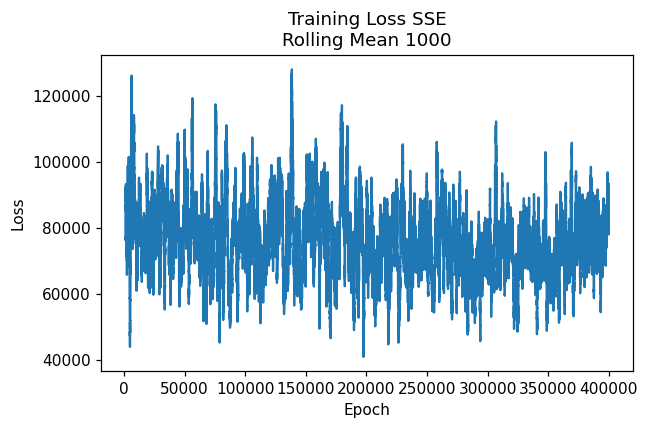

In [42]:
# Plot rolling average window of training loss values.
plt.figure(dpi=110)
window = 1000
rolling_mean = (
    np.convolve(model.plain_log["train_loss"], np.ones(window), "valid") / window
)
rolling_start = 100
plt.plot(
    np.arange(
        window + rolling_start,
        window + rolling_start + len(rolling_mean[rolling_start:]),
    ),
    rolling_mean[rolling_start:],
)
plt.title("Training Loss " + train_loss_name + f"\nRolling Mean {window}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
# plt.ylim(0, 1)
print(np.median(rolling_mean))
print(
    np.mean(model.plain_log["train_loss"][: window + rolling_start]),
    np.var(model.plain_log["train_loss"][: window + rolling_start]),
    np.max(model.plain_log["train_loss"][: window + rolling_start]),
)

plt.savefig(experiment_results_dir / "train_loss.png")

# Model Testing/Evaluation

## Testing Loop

In [43]:
# Store test reconstructions along the way for later visualization.
test_vol_viz = Addict()

# Structure is as follows:
# {subj_id_1:
#    fr_mask: np.ndarray,
#    dti: {
#          diqt: np.ndarray,
#          spline: np.ndarray,
#          fr: np.ndarray,
#          lr: np.ndarray
#          ...
#         }
#    fa: {
#         diqt: np.ndarray,
#         ...
#        },
# pitn.data.norm.denormalize_batch(y, mean=fr_means, var=fr_vars, eps=self._norm_eps)
#  subj_id_2:
#     ....
# }

In [44]:
trainer.test(model, test_dataloaders=test_loader, ckpt_path=None)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.006246558477869257}
--------------------------------------------------------------------------------


[{'test_loss': 0.006246558477869257}]

In [45]:
# Store DIQT test reconstructions for visualization.
for subj in test_dataset.dry_iter():
    subj_id = subj.subj_id
    test_vol_viz[subj_id].dti.diqt = (
        model.plain_log.viz.test_preds[subj_id].get_output_tensor().cpu().numpy()
    )

In [46]:
test_loss_name = "RMSE"
test_loss_log_file = experiment_results_dir / "test_loss.csv"

with open(log_txt_file, "a+") as f:
    f.write(f"Test loss function: {test_loss_name}\n")

row_iter = enumerate(model.plain_log["test_loss"])
test_loss_tabular = "".join([f"{batch_idx}, {loss}\n" for batch_idx, loss in row_iter])

with open(test_loss_log_file, "a+") as f:
    f.write("batch_idx, loss\n")
    f.write(test_loss_tabular)

## Spline Baseline

In [47]:
spline_test_log = dict()

for subj in test_dataset.dry_iter():
    #     breakpoint()
    print("---")
    target_shape = subj["fr_dti"]["data"].cpu().numpy().shape
    interp_spline = scipy.ndimage.zoom(
        subj["lr_dti"]["data"].cpu().numpy(),
        zoom=(1, downsample_factor, downsample_factor, downsample_factor),
        order=exp_params.spline.order,
    )
    # 0-out everything not in the mask, for both visualization and quantification.
    interp_spline = interp_spline * subj["fr_brain_mask"]["data"].bool().cpu().numpy()
    if interp_spline.shape != target_shape:
        # Crop off the end few voxels to account for the lack of padding used in full-
        # volume inference.
        interp_spline = interp_spline[
            :, : target_shape[1], : target_shape[2], : target_shape[3]
        ]
    subj_id = subj["subj_id"]
    print(f"Subj {subj_id} done")

    spline_test_log[subj_id] = interp_spline

---
Subj 224022 done
---
Subj 140117 done
---
Subj 810439 done
---
Subj 185947 done


In [48]:
spline_loss = list()

# Calculate spline loss for test images.
for subj in test_dataset.dry_iter():
    #     breakpoint()
    # De-normalize the ground truth volume.
    subj_id = subj["subj_id"]
    spline_pred = spline_test_log[subj_id]

    gt = subj["fr_dti"]["data"]
    gt_means = torch.from_numpy(subj["fr_means"])
    gt_vars = torch.from_numpy(subj["fr_vars"])
    lr_means = torch.from_numpy(subj["lr_means"])
    lr_vars = torch.from_numpy(subj["lr_vars"])

    brain_mask = subj["fr_brain_mask"]["data"].bool().cpu().numpy()[0]
    if (
        exp_params.data.data_norm_method is not None
        and "channel" in data_norm_method.casefold()
    ):
        print("De-normalizing")
        gt = pitn.data.norm.denormalize_batch(gt, mean=gt_means, var=gt_vars, eps=1e-10)
        spline_pred = torch.from_numpy(spline_pred)
        spline_pred = pitn.data.norm.denormalize_batch(
            spline_pred, mean=gt_means, var=gt_vars, eps=1e-10
        )

        spline_pred = spline_pred.detach().cpu().numpy()

    gt = gt.detach().cpu().numpy()

    # Calculate the RMSE of just the values found in the mask.
    se = (gt - spline_pred) ** 2
    se = se[:, brain_mask]
    loss = np.sqrt(se.mean())
    spline_loss.append(loss)

    # Store spline test reconstructions for visualization.
    test_vol_viz[subj_id].dti.spline = spline_pred.copy()

# Find the grand mean of the spline RMSE's
spline_loss_mean = np.mean(spline_loss)
print(spline_loss_mean)

De-normalizing
De-normalizing
De-normalizing
De-normalizing
0.0022176346


## Evaluation Visualization

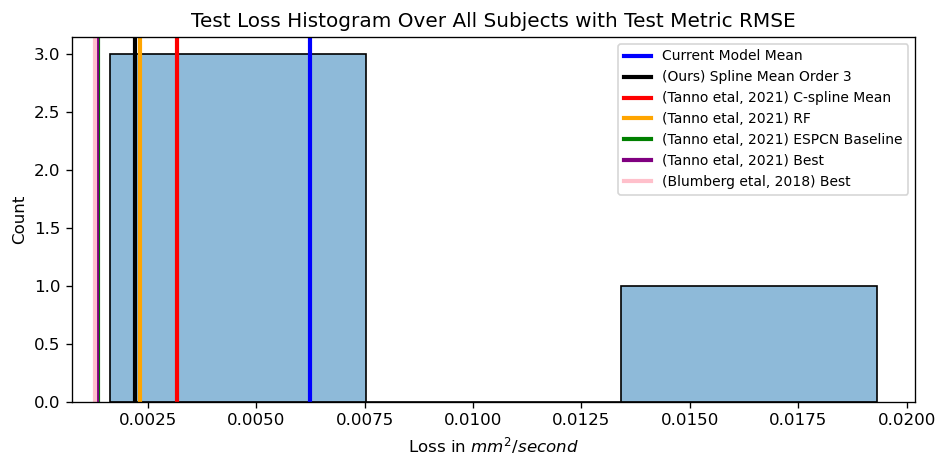

In [71]:
# Plot testing loss values over all patches.
fig, ax_prob = plt.subplots(figsize=(8, 4), dpi=120)
log_scale = False

sns.histplot(
    model.plain_log["test_loss"],
    alpha=0.5,
    stat="count",
    log_scale=log_scale,
    ax=ax_prob,
    legend=False,
)
plt.xlabel("Loss in $mm^2/second$")

# Draw means of different comparison models.
comparison_kwargs = {"ls": "-", "lw": 2.5}
# Plot the current DNN model performance.
plt.axvline(
    np.asarray(model.plain_log["test_loss"]).mean(),
    label="Current Model Mean",
    color="blue",
    **comparison_kwargs,
)
# Our spline mean performance.
plt.axvline(
    spline_loss_mean,
    label=f"(Ours) Spline Mean Order {exp_params.spline.order}",
    color="black",
    **comparison_kwargs,
)
# Tanno, et. al., 2021 model comparisons.
# Taken from Table 2, HCP exterior.
plt.axvline(
    31.738e-4,
    label="(Tanno etal, 2021) C-spline Mean",
    color="red",
    **comparison_kwargs,
)
plt.axvline(
    23.139e-4,
    label="(Tanno etal, 2021) RF",
    color="orange",
    **comparison_kwargs,
)
plt.axvline(
    13.609e-4,
    label="(Tanno etal, 2021) ESPCN Baseline",
    color="green",
    **comparison_kwargs,
)
plt.axvline(
    13.412e-4,
    label="(Tanno etal, 2021) Best",
    color="purple",
    **comparison_kwargs,
)
# Best performing Blumberg, et. al., 2018 paper model.
plt.axvline(
    12.78e-4,
    label="(Blumberg etal, 2018) Best",
    color="pink",
    **comparison_kwargs,
)

plt.legend(fontsize="small")
plt.title(f"Test Loss Histogram Over All Subjects with Test Metric {test_loss_name}")
plt.savefig(experiment_results_dir / "test_loss_hist.png")

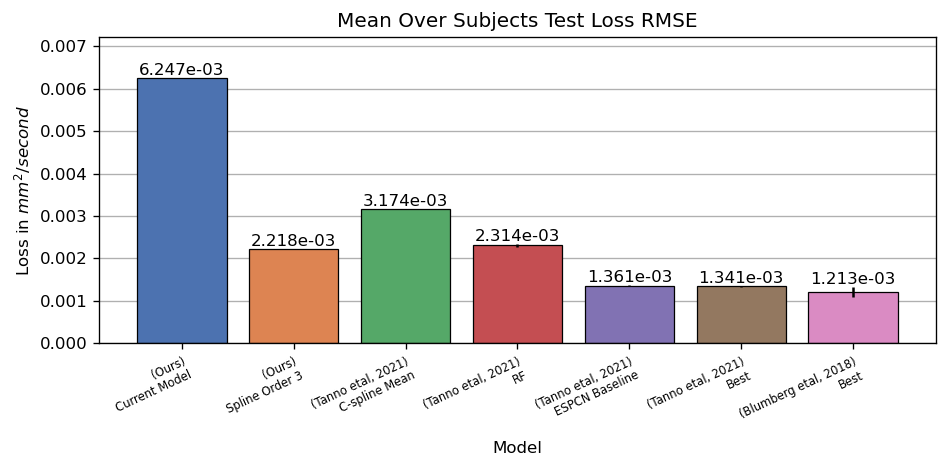

In [50]:
# Plot testing loss values over all patches.
fig, ax = plt.subplots(figsize=(8, 4), dpi=120)

models = (
    "(Ours)\nCurrent Model",
    f"(Ours)\nSpline Order {exp_params.spline.order}",
    "(Tanno etal, 2021)\nC-spline Mean",
    "(Tanno etal, 2021)\nRF",
    "(Tanno etal, 2021)\nESPCN Baseline",
    "(Tanno etal, 2021)\nBest",
    "(Blumberg etal, 2018)\nBest",
)

rmse_scores = (
    np.asarray(model.plain_log["test_loss"]).mean(),
    spline_loss_mean,
    31.738e-4,
    23.139e-4,
    13.609e-4,
    13.412e-4,
    12.13e-4,
)
rmse_std_error = np.asarray([0, 0, 0, 0.351e-4, 0.084e-4, 0.041e-4, 1.24e-4])

ax.grid(True, axis="y", zorder=1000)
ax.set_axisbelow(True)
ax.bar(
    models,
    rmse_scores,
    yerr=rmse_std_error,
    color=sns.color_palette("deep", n_colors=len(rmse_scores)),
    edgecolor="black",
    lw=0.75,
)

for container in ax.containers:
    if isinstance(container, mpl.container.BarContainer):
        ax.bar_label(container, fmt="%.3e")

ax.set_ylim(bottom=0, top=ax.get_ylim()[1] * 1.1)
ax.set_xlabel("Model")
ax.set_ylabel("Loss in $mm^2/second$")

ax.set_title(f"Mean Over Subjects Test Loss {test_loss_name}")
ax.set_xticks(models)
ax.set_xticklabels(
    models, fontsize="x-small", rotation=25, ha="right", rotation_mode="anchor"
)
plt.savefig(experiment_results_dir / "test_loss_bar.png")

In [51]:
print(model.plain_log["test_loss"])
print(np.mean(model.plain_log["test_loss"]))

[0.001802477752789855, 0.019313715398311615, 0.002235413296148181, 0.0016346274642273784]
0.006246558477869257


In [52]:
print(spline_loss)
print(spline_loss_mean)

[0.0007398294, 0.00046899501, 0.0005586261, 0.0071030883]
0.0022176346


In [53]:
logger.add_histogram("test/rmse_dist", np.asarray(model.plain_log["test_loss"]))

## Save out metrics and Hyperparameters

In [54]:
compare_hparams.metric["hparam/rmse"] = np.mean(model.plain_log["test_loss"])
with open(log_txt_file, "a+") as f:
    f.write(f"Mean RMSE Testing Value: {np.mean(model.plain_log['test_loss'])}\n")
    f.write(f"Mean RMSE Spline Value: {spline_loss_mean}\n")

logger.add_scalar("metric/rmse", np.mean(model.plain_log["test_loss"]))
logger.add_scalar("metric/spline", spline_loss_mean)

# Whole-Volume Visualization

## Setup

In [55]:
# Debug flag(s)
disable_fig_save = False

In [72]:
# Create full 3D volume of full-res ground truth, low-res downsample, full-res mask, and
# full-res predictions.

with torch.no_grad():

    for subj_i in test_dataset.dry_iter():
        subj = copy.copy(subj_i)
        subj_id = subj["subj_id"]
        print(f"Starting subject {subj_id}")

        # Collect all variants of the volume and aggregate into one container object.
        fr_vol = subj["fr_dti"]["data"].clone()
        lr_vol = subj["lr_dti"]["data"].clone()

        full_res_predicted = torch.from_numpy(test_vol_viz[subj_id].dti.diqt.copy())
        full_res_spline = torch.from_numpy(test_vol_viz[subj_id].dti.spline.copy())

        #         warnings.warn("======== Skipping all de-normalization for visualization.")
        #         if False:
        if data_norm_method is not None and "channel" in data_norm_method.casefold():
            print("Normalizing")
            fr_means = torch.as_tensor(subj["fr_means"]).to(fr_vol).clone()
            fr_vars = torch.as_tensor(subj["fr_vars"]).to(fr_vol).clone()

            lr_means = torch.as_tensor(subj["lr_means"]).to(lr_vol).clone()
            lr_vars = torch.as_tensor(subj["lr_vars"]).to(lr_vol).clone()

            fr_vol = pitn.data.norm.denormalize_dti(
                fr_vol, mean=fr_means, var=fr_vars
            ).clone()
            lr_vol = pitn.data.norm.denormalize_dti(
                lr_vol, mean=fr_means, var=fr_vars
            ).clone()

        #             full_res_spline = pitn.data.norm.denormalize_dti(
        #                 full_res_spline, lr_means, lr_vars
        #             )
        #             full_res_predicted = pitn.data.norm.denormalize_dti(
        #                 full_res_predicted, lr_means, lr_vars
        #             )
        # Zero-out all voxels outside the mask.

        fr_mask = subj["fr_brain_mask"]["data"].bool().clone()
        full_res_spline = full_res_spline * fr_mask.to(full_res_spline).bool()
        fr_vol = fr_vol * fr_mask.to(fr_vol).bool()
        full_res_predicted = full_res_predicted * fr_mask.to(full_res_predicted).bool()
        lr_vol = lr_vol * subj["lr_brain_mask"]["data"].to(lr_vol).bool()
        abs_error = torch.abs(full_res_predicted - fr_vol)

        print(
            "RMSE of Non-Normalized FR to itself normalized: ",
            torch.sqrt(
                (
                    (
                        torch.masked_select(fr_vol, fr_mask)
                        - torch.masked_select(subj["fr_dti"]["data"], fr_mask)
                    )
                    ** 2
                ).mean()
            ),
        )

        #         print(
        #             "RMSE of LR to itself: ",
        #             torch.sqrt(((lr_vol - subj["lr_dti"]["data"]) ** 2).mean()),
        #         )

        test_vol_viz[subj.subj_id].dti.update(
            fr=fr_vol.cpu().numpy(),
            lr=lr_vol.cpu().numpy(),
            diqt=full_res_predicted.cpu().numpy(),
            spline=full_res_spline.cpu().numpy(),
        )

        test_vol_viz[subj.subj_id].fa.update(
            itertools.starmap(
                lambda k, v: (k, pitn.viz.fa_map(test_vol_viz[subj_id].dti[k])),
                test_vol_viz[subj_id].dti.items(),
            )
        )
        test_vol_viz[subj_id].fr_mask = fr_mask.cpu().numpy()
        test_vol_viz[subj_id].dti.abs_error = abs_error.cpu().numpy()

        #         subj_result = SubjResult(
        #             subj_id=subj["subj_id"],
        #             full_res=fr_vol,
        #             low_res=lr_vol,
        #             full_res_predicted=full_res_predicted,
        #             full_res_cubic_spline=full_res_cubic_spline,
        #         )

        #         test_vol_results.append(subj_result)
        print(f"Finished subject {subj_id}")

Starting subject 224022
Normalizing
RMSE of Non-Normalized FR to itself normalized:  tensor(0.9974)
Finished subject 224022
Starting subject 140117
Normalizing
RMSE of Non-Normalized FR to itself normalized:  tensor(0.9990)
Finished subject 140117
Starting subject 810439
Normalizing
RMSE of Non-Normalized FR to itself normalized:  tensor(0.9977)
Finished subject 810439
Starting subject 185947
Normalizing
RMSE of Non-Normalized FR to itself normalized:  tensor(0.9955)
Finished subject 185947


In [57]:
# Save out all network predictions to Nifti2 files and compress them into a zip archive.
if not disable_fig_save:
    img_names = list()
    for subj_id, viz in test_vol_viz.items():
        pred_vol = viz.dti.diqt
        affine = subj_data[subj_id]["fr_dti"].affine
        nib_img = nib.Nifti2Image(pred_vol, affine)

        filename = experiment_results_dir / f"{subj_id}_predicted_dti.nii.gz"
        nib.save(nib_img, str(filename))
        img_names.append(filename)

    with zipfile.ZipFile(experiment_results_dir / "predicted_dti.zip", "w") as fzip:
        for filename in img_names:
            fzip.write(
                filename,
                arcname=filename.name,
                compress_type=zipfile.ZIP_DEFLATED,
                compresslevel=6,
            )
            os.remove(filename)
    # Make sure we exit the 'with' statement above.
    print("Done with files")

Done with files


In [58]:
viz_subj_idx = 2
viz_subj_id = list(test_vol_viz.keys())[viz_subj_idx]

## FA-Weighted Direction Maps

In [73]:
# Generate FA-weighted diffusion direction map for prediction.
pred_dir_map = pitn.viz.direction_map(test_vol_viz[viz_subj_id].dti.diqt)
# Set channels last for matplotlib
pred_dir_map = pred_dir_map.transpose(1, 2, 3, 0)
test_vol_viz[viz_subj_id].color_fa.diqt = pred_dir_map

spline_dir_map = pitn.viz.direction_map(test_vol_viz[viz_subj_id].dti.spline)
# Set channels last for matplotlib
spline_dir_map = spline_dir_map.transpose(1, 2, 3, 0)
test_vol_viz[viz_subj_id].color_fa.spline = spline_dir_map

fr_dir_map = pitn.viz.direction_map(test_vol_viz[viz_subj_id].dti.fr)
# Set channels last for matplotlib
fr_dir_map = fr_dir_map.transpose(1, 2, 3, 0)
test_vol_viz[viz_subj_id].color_fa.fr = fr_dir_map

lr_dir_map = pitn.viz.direction_map(test_vol_viz[viz_subj_id].dti.lr)
# Set channels last for matplotlib
lr_dir_map = lr_dir_map.transpose(1, 2, 3, 0)
test_vol_viz[viz_subj_id].color_fa.lr = lr_dir_map

In [60]:
slice_idx = (slice(None, None, None), slice(None, None, None), 86)
low_res_slice_idx = tuple(s // 2 if isinstance(s, int) else s for s in slice_idx)
print(slice_idx)
print(low_res_slice_idx)

(slice(None, None, None), slice(None, None, None), 86)
(slice(None, None, None), slice(None, None, None), 43)


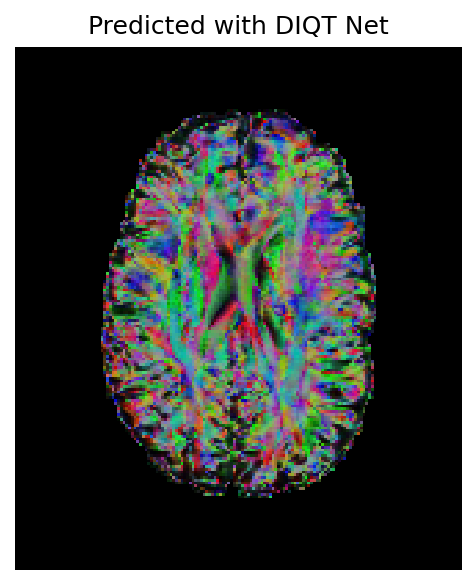

In [61]:
plt.figure(dpi=150)
plt.imshow(np.rot90(pred_dir_map[slice_idx]), interpolation="none")
plt.axis("off")
plt.title("Predicted with DIQT Net")
if not disable_fig_save:
    plt.savefig(experiment_results_dir / "pred_dir_map_sample.png");

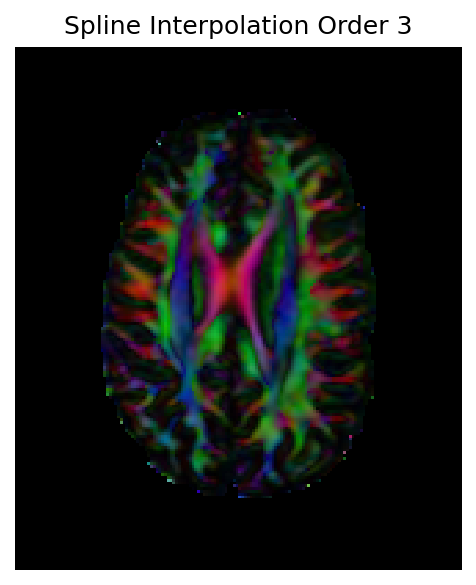

In [62]:
plt.figure(dpi=150)
plt.imshow(np.rot90(spline_dir_map[slice_idx]), interpolation="none")
plt.axis("off")
plt.title(f"Spline Interpolation Order {exp_params.spline.order}")
if not disable_fig_save:
    plt.savefig(experiment_results_dir / "cubic_spline_dir_map_sample.png");

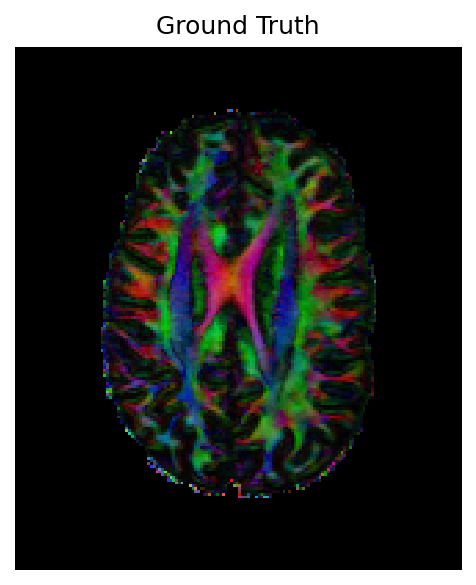

In [63]:
plt.figure(dpi=150)
plt.imshow(np.rot90(fr_dir_map[slice_idx]), interpolation="none")
# plt.colorbar()
plt.axis("off")
plt.title("Ground Truth")
if not disable_fig_save:
    plt.savefig(experiment_results_dir / "ground_truth_dir_map_sample.png")

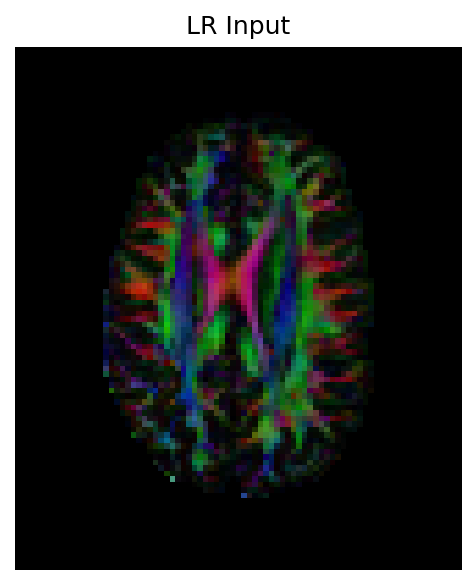

In [74]:
plt.figure(dpi=150)
plt.imshow(np.rot90(lr_dir_map[low_res_slice_idx]), interpolation="none")
plt.axis("off")
plt.title("LR Input")
if not disable_fig_save:
    plt.savefig(experiment_results_dir / "low_res_map_sample.png");

## DTI Channel-Wise Visualization

In [65]:
channel_names = [
    "$D_{x,x}$",
    "$D_{x,y}$",
    "$D_{y,y}$",
    "$D_{x,z}$",
    "$D_{y,z}$",
    "$D_{z,z}$",
]
dti_names = [
    "Full-Res",
    "Low-Res Input",
    f"Spline Order {exp_params.spline.order}",
    "Predicted",
    "Absolute Error\nFR vs. Predicted",
]

### Per-Image Normalization

/tmp/ipykernel_173232/2051902678.py:52: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.

/opt/miniconda/envs/pitn/lib/python3.8/site-packages/IPython/core/pylabtools.py:134: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



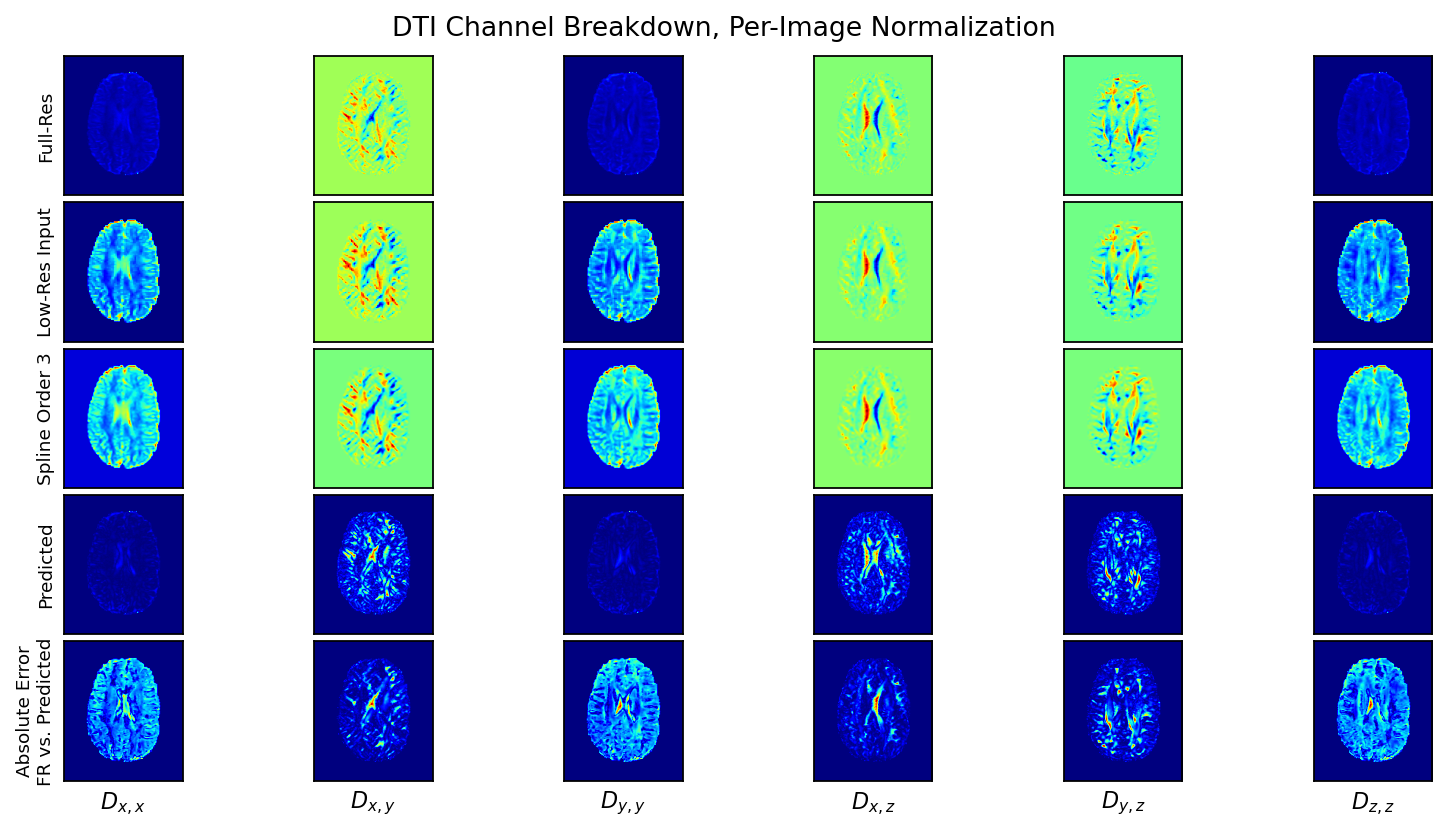

In [75]:
# Display all 6 DTIs for ground truth, predicted, and root squared error

cmap = "jet"

dtis = [
    test_vol_viz[viz_subj_id].dti.fr[(slice(None), *slice_idx)],
    test_vol_viz[viz_subj_id].dti.lr[(slice(None), *low_res_slice_idx)],
    test_vol_viz[viz_subj_id].dti.spline[(slice(None), *slice_idx)],
    test_vol_viz[viz_subj_id].dti.diqt[(slice(None), *slice_idx)],
    test_vol_viz[viz_subj_id].dti.abs_error[(slice(None), *slice_idx)],
]

nrows = len(dtis)
ncols = len(channel_names)

fig = plt.figure(figsize=(12, 6), dpi=160)

grid = mpl.gridspec.GridSpec(
    nrows,
    ncols,
    figure=fig,
    hspace=0.05,
    wspace=0.05,
)

max_subplot_height = 0
for i_row in range(nrows):
    dti = dtis[i_row]

    for j_col in range(ncols):
        ax = fig.add_subplot(grid[i_row, j_col])
        ax.imshow(np.rot90(dti[j_col]), cmap=cmap, interpolation=None)
        if ax.get_subplotspec().is_first_col():
            ax.set_ylabel(dti_names[i_row], size="small")
        if ax.get_subplotspec().is_last_row():
            ax.set_xlabel(channel_names[j_col])

        # Update highest subplot to put the `suptitle` later on.
        max_subplot_height = max(
            max_subplot_height, ax.get_position(original=False).get_points()[1, 1]
        )
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
plt.suptitle(
    "DTI Channel Breakdown, Per-Image Normalization",
    y=max_subplot_height + 0.015,
    verticalalignment="bottom",
)
if not disable_fig_save:
    plt.savefig(experiment_results_dir / "DTI_channel_sample_per_img_norm.png");

### Global Normalization

/tmp/ipykernel_173232/1647732608.py:77: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



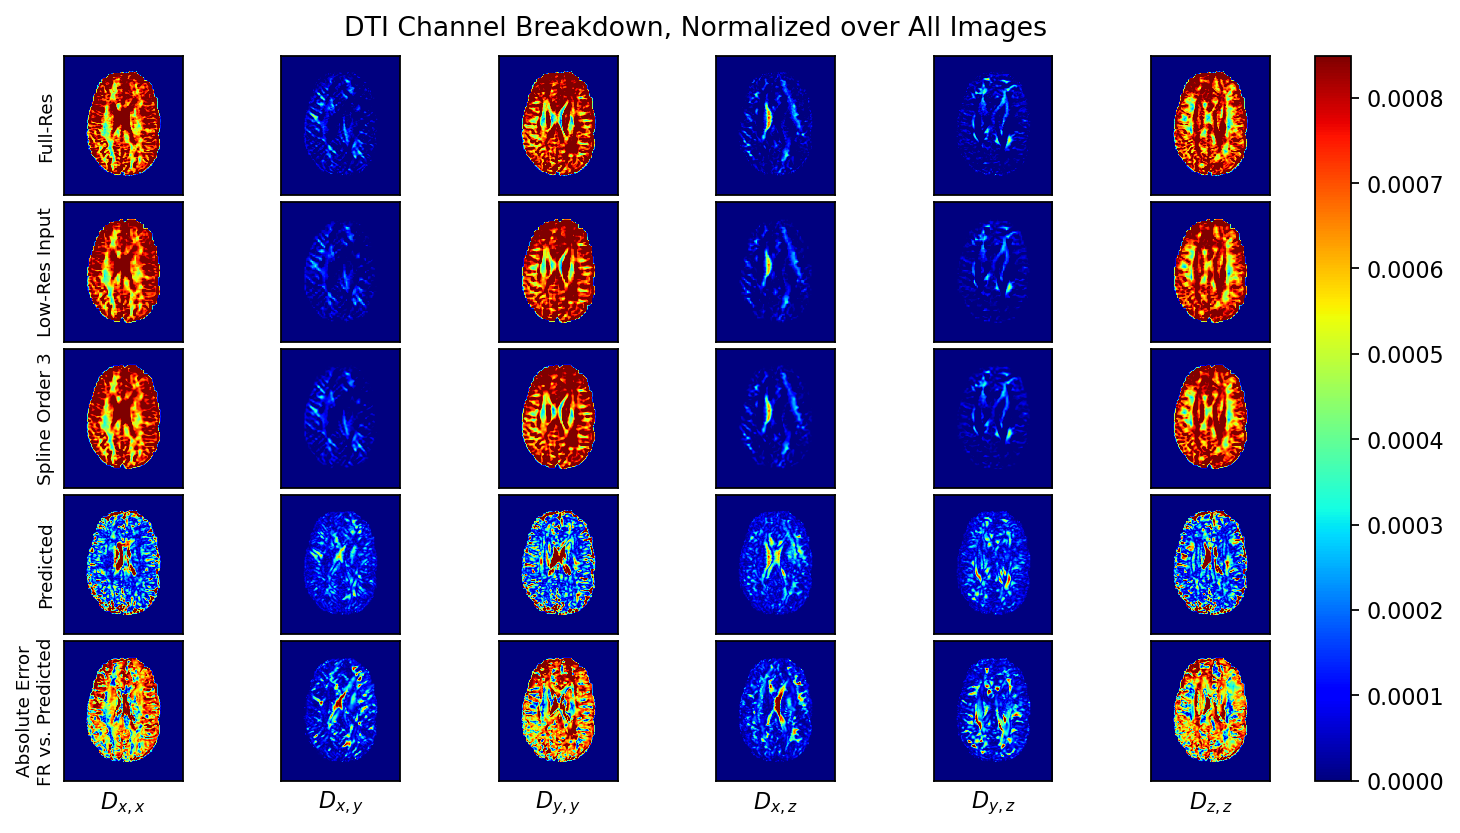

In [76]:
# Display all 6 DTIs for ground truth, predicted, and root squared error

cmap = "jet"

dtis = [
    test_vol_viz[viz_subj_id].dti.fr[(slice(None), *slice_idx)],
    test_vol_viz[viz_subj_id].dti.lr[(slice(None), *low_res_slice_idx)],
    test_vol_viz[viz_subj_id].dti.spline[(slice(None), *slice_idx)],
    test_vol_viz[viz_subj_id].dti.diqt[(slice(None), *slice_idx)],
    test_vol_viz[viz_subj_id].dti.abs_error[(slice(None), *slice_idx)],
]

nrows = len(dtis)
ncols = len(channel_names)

# Don't take the absolute max and min values, as there exist some extreme (e.g., > 3
# orders of magnitude) outliers. Instead, take some percente quantile.
# Reshape and concatenate the dtis in order to compute the quantiles of images with
# different shapes (e.g., the low-res input patch).
max_dti = np.quantile(np.concatenate([di.reshape(6, -1) for di in dtis], axis=1), 0.95)
min_dti = np.quantile(np.concatenate([di.reshape(6, -1) for di in dtis], axis=1), 0.05)

nrows = len(dtis)
ncols = len(channel_names)

fig = plt.figure(figsize=(12, 6), dpi=160)

grid = mpl.gridspec.GridSpec(
    nrows,
    ncols,
    figure=fig,
    hspace=0.05,
    wspace=0.05,
)
axs = list()
max_subplot_height = 0
for i_row in range(nrows):
    dti = dtis[i_row]

    for j_col in range(ncols):
        ax = fig.add_subplot(grid[i_row, j_col])
        ax.imshow(
            np.rot90(dti[j_col]),
            cmap=cmap,
            interpolation=None,
            vmin=min_dti,
            vmax=max_dti,
        )
        if ax.get_subplotspec().is_first_col():
            ax.set_ylabel(dti_names[i_row], size="small")
        if ax.get_subplotspec().is_last_row():
            ax.set_xlabel(channel_names[j_col])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        # Update highest subplot to put the `suptitle` later on.
        max_subplot_height = max(
            max_subplot_height, ax.get_position(original=False).get_points()[1, 1]
        )
        axs.append(ax)

color_norm = mpl.colors.Normalize(vmin=min_dti, vmax=max_dti)
fig.colorbar(
    mpl.cm.ScalarMappable(norm=color_norm, cmap=cmap),
    ax=axs,
    location="right",
    fraction=0.1,
    pad=0.03,
)
plt.suptitle(
    "DTI Channel Breakdown, Normalized over All Images",
    y=max_subplot_height + 0.015,
    verticalalignment="bottom",
)
if not disable_fig_save:
    plt.savefig(experiment_results_dir / "DTI_channel_sample_global_norm.png");

### Channel-Wise Normalization

/tmp/ipykernel_173232/888095140.py:102: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



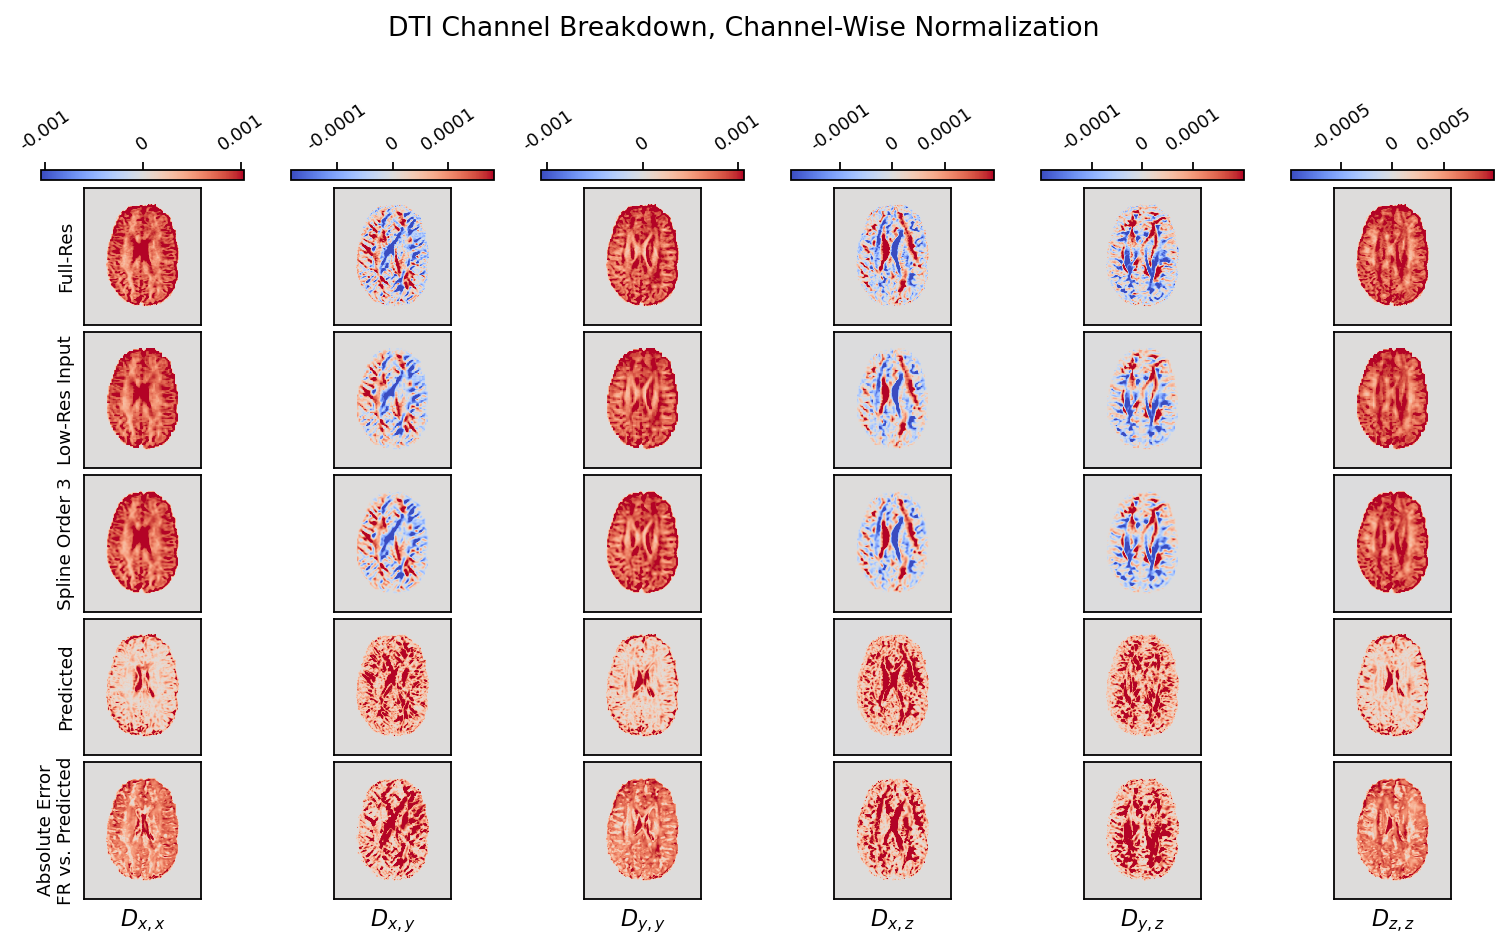

In [77]:
# Display all 6 DTIs for ground truth, predicted, low-res input, and root squared error
# Normalize by index in the DTI coefficients.
# Reshape and concatenate the dtis in order to compute the quantiles of images with
# different shapes (e.g., the low-res input patch).

cmap = "coolwarm"
dtis = [
    test_vol_viz[viz_subj_id].dti.fr[(slice(None), *slice_idx)],
    test_vol_viz[viz_subj_id].dti.lr[(slice(None), *low_res_slice_idx)],
    test_vol_viz[viz_subj_id].dti.spline[(slice(None), *slice_idx)],
    test_vol_viz[viz_subj_id].dti.diqt[(slice(None), *slice_idx)],
    test_vol_viz[viz_subj_id].dti.abs_error[(slice(None), *slice_idx)],
]

nrows = len(dtis)
ncols = len(channel_names)

# Don't take the absolute max and min values, as there exist some extreme (e.g., > 3
# orders of magnitude) outliers. Instead, take some percente quantile.
max_dtis = np.quantile(
    np.concatenate([di.reshape(6, -1) for di in dtis], axis=1), 0.95, axis=1
)
min_dtis = np.quantile(
    np.concatenate([di.reshape(6, -1) for di in dtis], axis=1), 0.05, axis=1
)

max_dtis = np.max(np.abs([max_dtis, min_dtis]), axis=0)
min_dtis = -1 * max_dtis

nrows = len(dtis)
ncols = len(channel_names)

fig = plt.figure(figsize=(12, 7), dpi=160)

grid = mpl.gridspec.GridSpec(
    nrows,
    ncols,
    figure=fig,
    hspace=0.05,
    wspace=0.05,
)

axs = list()
max_subplot_height = 0
for i_row in range(nrows):
    dti = dtis[i_row]
    axs_cols = list()

    for j_col in range(ncols):
        ax = fig.add_subplot(grid[i_row, j_col])
        ax.imshow(
            np.rot90(dti[j_col]),
            cmap=cmap,
            interpolation=None,
            vmin=min_dtis[j_col],
            vmax=max_dtis[j_col],
        )
        if ax.get_subplotspec().is_first_col():
            ax.set_ylabel(dti_names[i_row], size="small")
        if ax.get_subplotspec().is_last_row():
            ax.set_xlabel(channel_names[j_col])

        # Update highest subplot to put the `suptitle` later on.
        max_subplot_height = max(
            max_subplot_height, ax.get_position(original=False).get_points()[1, 1]
        )
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])

        axs_cols.append(ax)

    axs.append(axs_cols)

# Place colorbars on each column.
for j_col in range(ncols):

    full_col_ax = [axs[i][j_col] for i in range(nrows)]

    color_norm = mpl.colors.Normalize(vmin=min_dtis[j_col], vmax=max_dtis[j_col])

    color_mappable = mpl.cm.ScalarMappable(norm=color_norm, cmap=cmap)
    cbar = fig.colorbar(
        color_mappable,
        ax=full_col_ax,
        location="top",
        orientation="horizontal",
        pad=0.01,
        shrink=0.85,
    )
    cbar.ax.tick_params(labelsize=8, rotation=35)
    cbar.ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:g}"))
#     cbar.ax.ticklabel_format(scilimits=(3, -3), useOffset=False)

plt.suptitle(
    "DTI Channel Breakdown, Channel-Wise Normalization",
    y=max_subplot_height + 0.01,
    verticalalignment="bottom",
)
if not disable_fig_save:
    plt.savefig(experiment_results_dir / "DTI_channel_sample_channel_wise_norm.png");

## FA Map

### Per-Image Normalization

In [137]:
# Slice locations for 2D visualization

half_fr_space_shape = np.asarray(test_vol_viz[viz_subj_id].fa.fr.shape) // 2
half_fr_space_shape = half_fr_space_shape.tolist()

slice_indices = [
    (half_fr_space_shape[0], slice(None, None, None), slice(None, None, None)),
    (slice(None, None, None), half_fr_space_shape[1], slice(None, None, None)),
    (slice(None, None, None), slice(None, None, None), half_fr_space_shape[2]),
]

low_res_slice_indices = list()
for slice_idx_i in slice_indices:
    slice_coords = tuple()
    for s in slice_idx_i:
        slice_coords = slice_coords + (s // 2 if isinstance(s, int) else s,)
    low_res_slice_indices.append(slice_coords)

print(slice_indices)
print()
print(low_res_slice_indices)

row_names = [
    "Saggital",
    "Coronal",
    "Horizontal",
]

model_names = [
    "Full-Res",
    "Low-Res Input",
    f"Spline Order {exp_params.spline.order}",
    "Predicted",
    "Absolute Error\nFR vs. Predicted",
]

nrows = len(row_names)
ncols = len(model_names)

[(81, slice(None, None, None), slice(None, None, None)), (slice(None, None, None), 95, slice(None, None, None)), (slice(None, None, None), slice(None, None, None), 81)]

[(40, slice(None, None, None), slice(None, None, None)), (slice(None, None, None), 47, slice(None, None, None)), (slice(None, None, None), slice(None, None, None), 40)]


In [138]:
imgs = dict()
for i_row, slice_i in enumerate(slice_indices):
    low_res_slice_i = low_res_slice_indices[i_row]
    imgs[i_row] = dict()
    col_imgs = [
        test_vol_viz[viz_subj_id].fa.fr[(*slice_i,)],
        test_vol_viz[viz_subj_id].fa.lr[(*low_res_slice_i,)],
        test_vol_viz[viz_subj_id].fa.spline[(*slice_i,)],
        test_vol_viz[viz_subj_id].fa.diqt[(*slice_i,)],
        test_vol_viz[viz_subj_id].fa.abs_error[(*slice_i,)],
    ]

    imgs[i_row].update(tuple(enumerate(col_imgs)))

/tmp/ipykernel_173232/1184558066.py:70: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



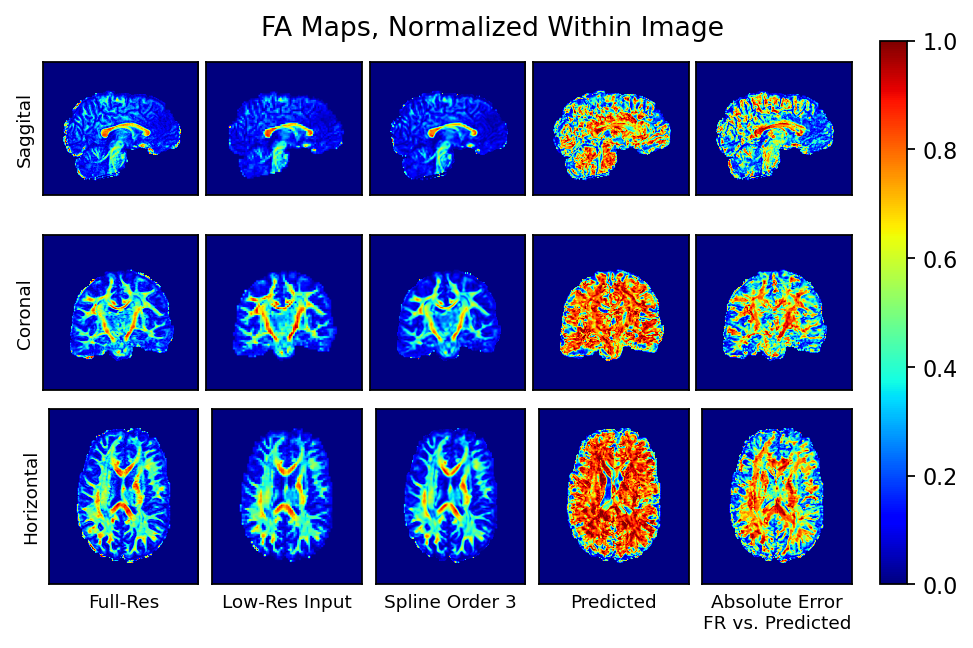

In [140]:
# Display all 6 DTIs for ground truth, predicted, and root squared error

cmap = "jet"
# Don't take the absolute max and min values, as there exist some extreme (e.g., > 3
# orders of magnitude) outliers. Instead, take some percente quantile.
# Concatenate the images in order to compute the quantiles of images with
# different shapes (e.g., the low-res input patch).
max_intensity = np.max(
    np.concatenate(
        [imgs[i][j] for (i, j) in itertools.product(range(nrows), range(ncols))],
        axis=None,
    )
)
min_intensity = np.min(
    np.concatenate(
        [imgs[i][j] for (i, j) in itertools.product(range(nrows), range(ncols))],
        axis=None,
    )
)

fig = plt.figure(figsize=(5 * 1.5, 3 * 1.5), dpi=160)

grid = mpl.gridspec.GridSpec(
    nrows,
    ncols,
    figure=fig,
    hspace=0.05,
    wspace=0.05,
)
axs = list()
max_subplot_height = 0
for i_row in range(nrows):
    img_row = imgs[i_row]

    for j_col in range(ncols):
        ax = fig.add_subplot(grid[i_row, j_col])
        ax.imshow(
            np.rot90(img_row[j_col]),
            cmap=cmap,
            interpolation=None,
        )
        if ax.get_subplotspec().is_first_col():
            ax.set_ylabel(row_names[i_row], size="small")
        if ax.get_subplotspec().is_last_row():
            ax.set_xlabel(model_names[j_col], size="small")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        # Update highest subplot to put the `suptitle` later on.
        max_subplot_height = max(
            max_subplot_height, ax.get_position(original=False).get_points()[1, 1]
        )
        axs.append(ax)

color_norm = mpl.colors.Normalize(vmin=min_intensity, vmax=max_intensity)
fig.colorbar(
    mpl.cm.ScalarMappable(norm=color_norm, cmap=cmap),
    ax=axs,
    location="right",
    fraction=0.1,
    pad=0.03,
)
plt.suptitle(
    "FA Maps, Normalized Within Image",
    y=max_subplot_height + 0.015,
    verticalalignment="bottom",
)
if not disable_fig_save:
    plt.savefig(experiment_results_dir / "fa_sample_per_img_norm.png");

### Global Normalization

/tmp/ipykernel_173232/3516803983.py:75: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



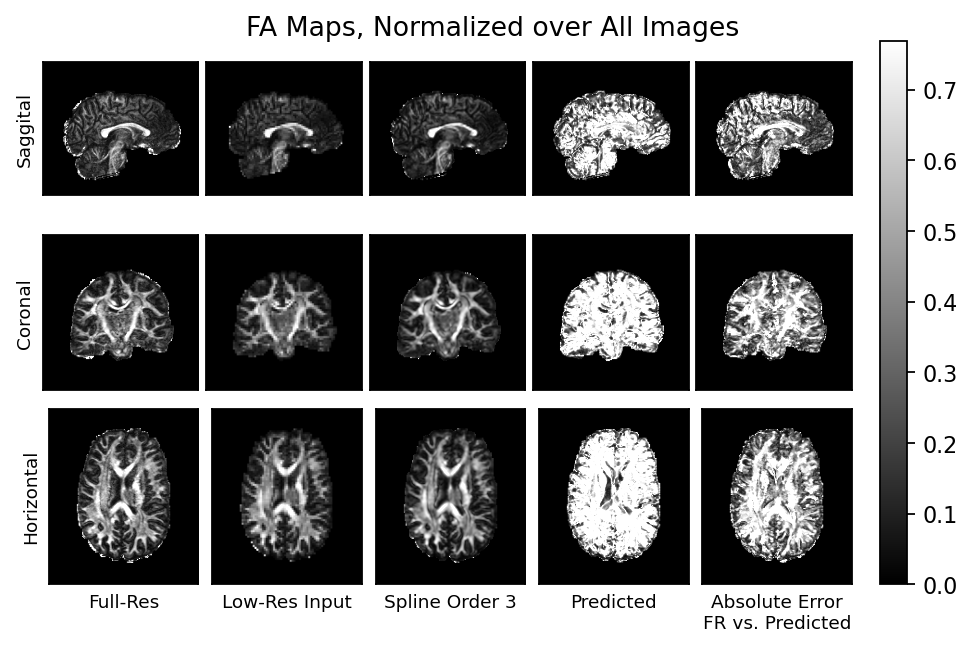

In [143]:
# Display all 6 DTIs for ground truth, predicted, and root squared error

cmap = "gist_gray"

# Don't take the absolute max and min values, as there exist some extreme (e.g., > 3
# orders of magnitude) outliers. Instead, take some percente quantile.
# Concatenate the images in order to compute the quantiles of images with
# different shapes (e.g., the low-res input patch).
max_intensity = np.quantile(
    np.concatenate(
        [imgs[i][j] for (i, j) in itertools.product(range(nrows), range(ncols))],
        axis=None,
    ),
    0.95,
)
min_intensity = np.quantile(
    np.concatenate(
        [imgs[i][j] for (i, j) in itertools.product(range(nrows), range(ncols))],
        axis=None,
    ),
    0.05,
)

fig = plt.figure(figsize=(5 * 1.5, 3 * 1.5), dpi=160)

grid = mpl.gridspec.GridSpec(
    nrows,
    ncols,
    figure=fig,
    hspace=0.05,
    wspace=0.05,
)
axs = list()
max_subplot_height = 0
for i_row in range(nrows):
    img_row = imgs[i_row]

    for j_col in range(ncols):
        ax = fig.add_subplot(grid[i_row, j_col])
        ax.imshow(
            np.rot90(img_row[j_col]),
            cmap=cmap,
            interpolation=None,
            vmin=min_intensity,
            vmax=max_intensity,
        )
        if ax.get_subplotspec().is_first_col():
            ax.set_ylabel(row_names[i_row], size="small")
        if ax.get_subplotspec().is_last_row():
            ax.set_xlabel(model_names[j_col], size="small")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        # Update highest subplot to put the `suptitle` later on.
        max_subplot_height = max(
            max_subplot_height, ax.get_position(original=False).get_points()[1, 1]
        )
        axs.append(ax)

color_norm = mpl.colors.Normalize(vmin=min_intensity, vmax=max_intensity)
fig.colorbar(
    mpl.cm.ScalarMappable(norm=color_norm, cmap=cmap),
    ax=axs,
    location="right",
    fraction=0.1,
    pad=0.03,
)
plt.suptitle(
    "FA Maps, Normalized over All Images",
    y=max_subplot_height + 0.015,
    verticalalignment="bottom",
)
if not disable_fig_save:
    plt.savefig(experiment_results_dir / "fa_sample_global_norm.png");

In [69]:
# Close tensorboard logger.
pl_logger.finalize("success")
# Experiment is complete, move the results directory to its final location.
if experiment_results_dir != final_experiment_results_dir:
    print("Moving out of tmp location")
    experiment_results_dir = experiment_results_dir.rename(final_experiment_results_dir)

Moving out of tmp location
